In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from collections import Counter
from sklearn.metrics import pairwise_distances_argmin_min
import timeit
import os
from scipy.stats import wilcoxon, fligner, ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from statsmodels.api import qqplot
from tqdm import tqdm

data_path = '/Users/mkamruz/Public/SNL/Projects/5UTR/Data/'

# Cluster distribution [2-13]

(10000000, 6)


ClsID              SeqID   Score Status  seq_index  seq_pred_sum
0      1   >gi|146|20|44.00  0.9032      M        146            20
1      1   >gi|175|21|52.00  0.8278      M        175            21
2      1   >gi|587|24|52.00  0.7784      E        587            24
3      1   >gi|989|11|44.00  0.8422      M        989            11
4      1  >gi|1321|22|48.00  0.8331      M       1321            22

Total clusters=55633
Total sequences=10000000


ClsID   Size
0        1  51689
1        2  47435
9       10  18088
100    101  13764
275    276  12118

2116


Size  NoOfClusters
0     1         15952
1     2            15
2     3            30
3     4            53
4     5            65

/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_12782/1679470893.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_size[np.logical_and(df_size.Size>1, True)], y='Size', x='NoOfClusters', palette='viridis',)


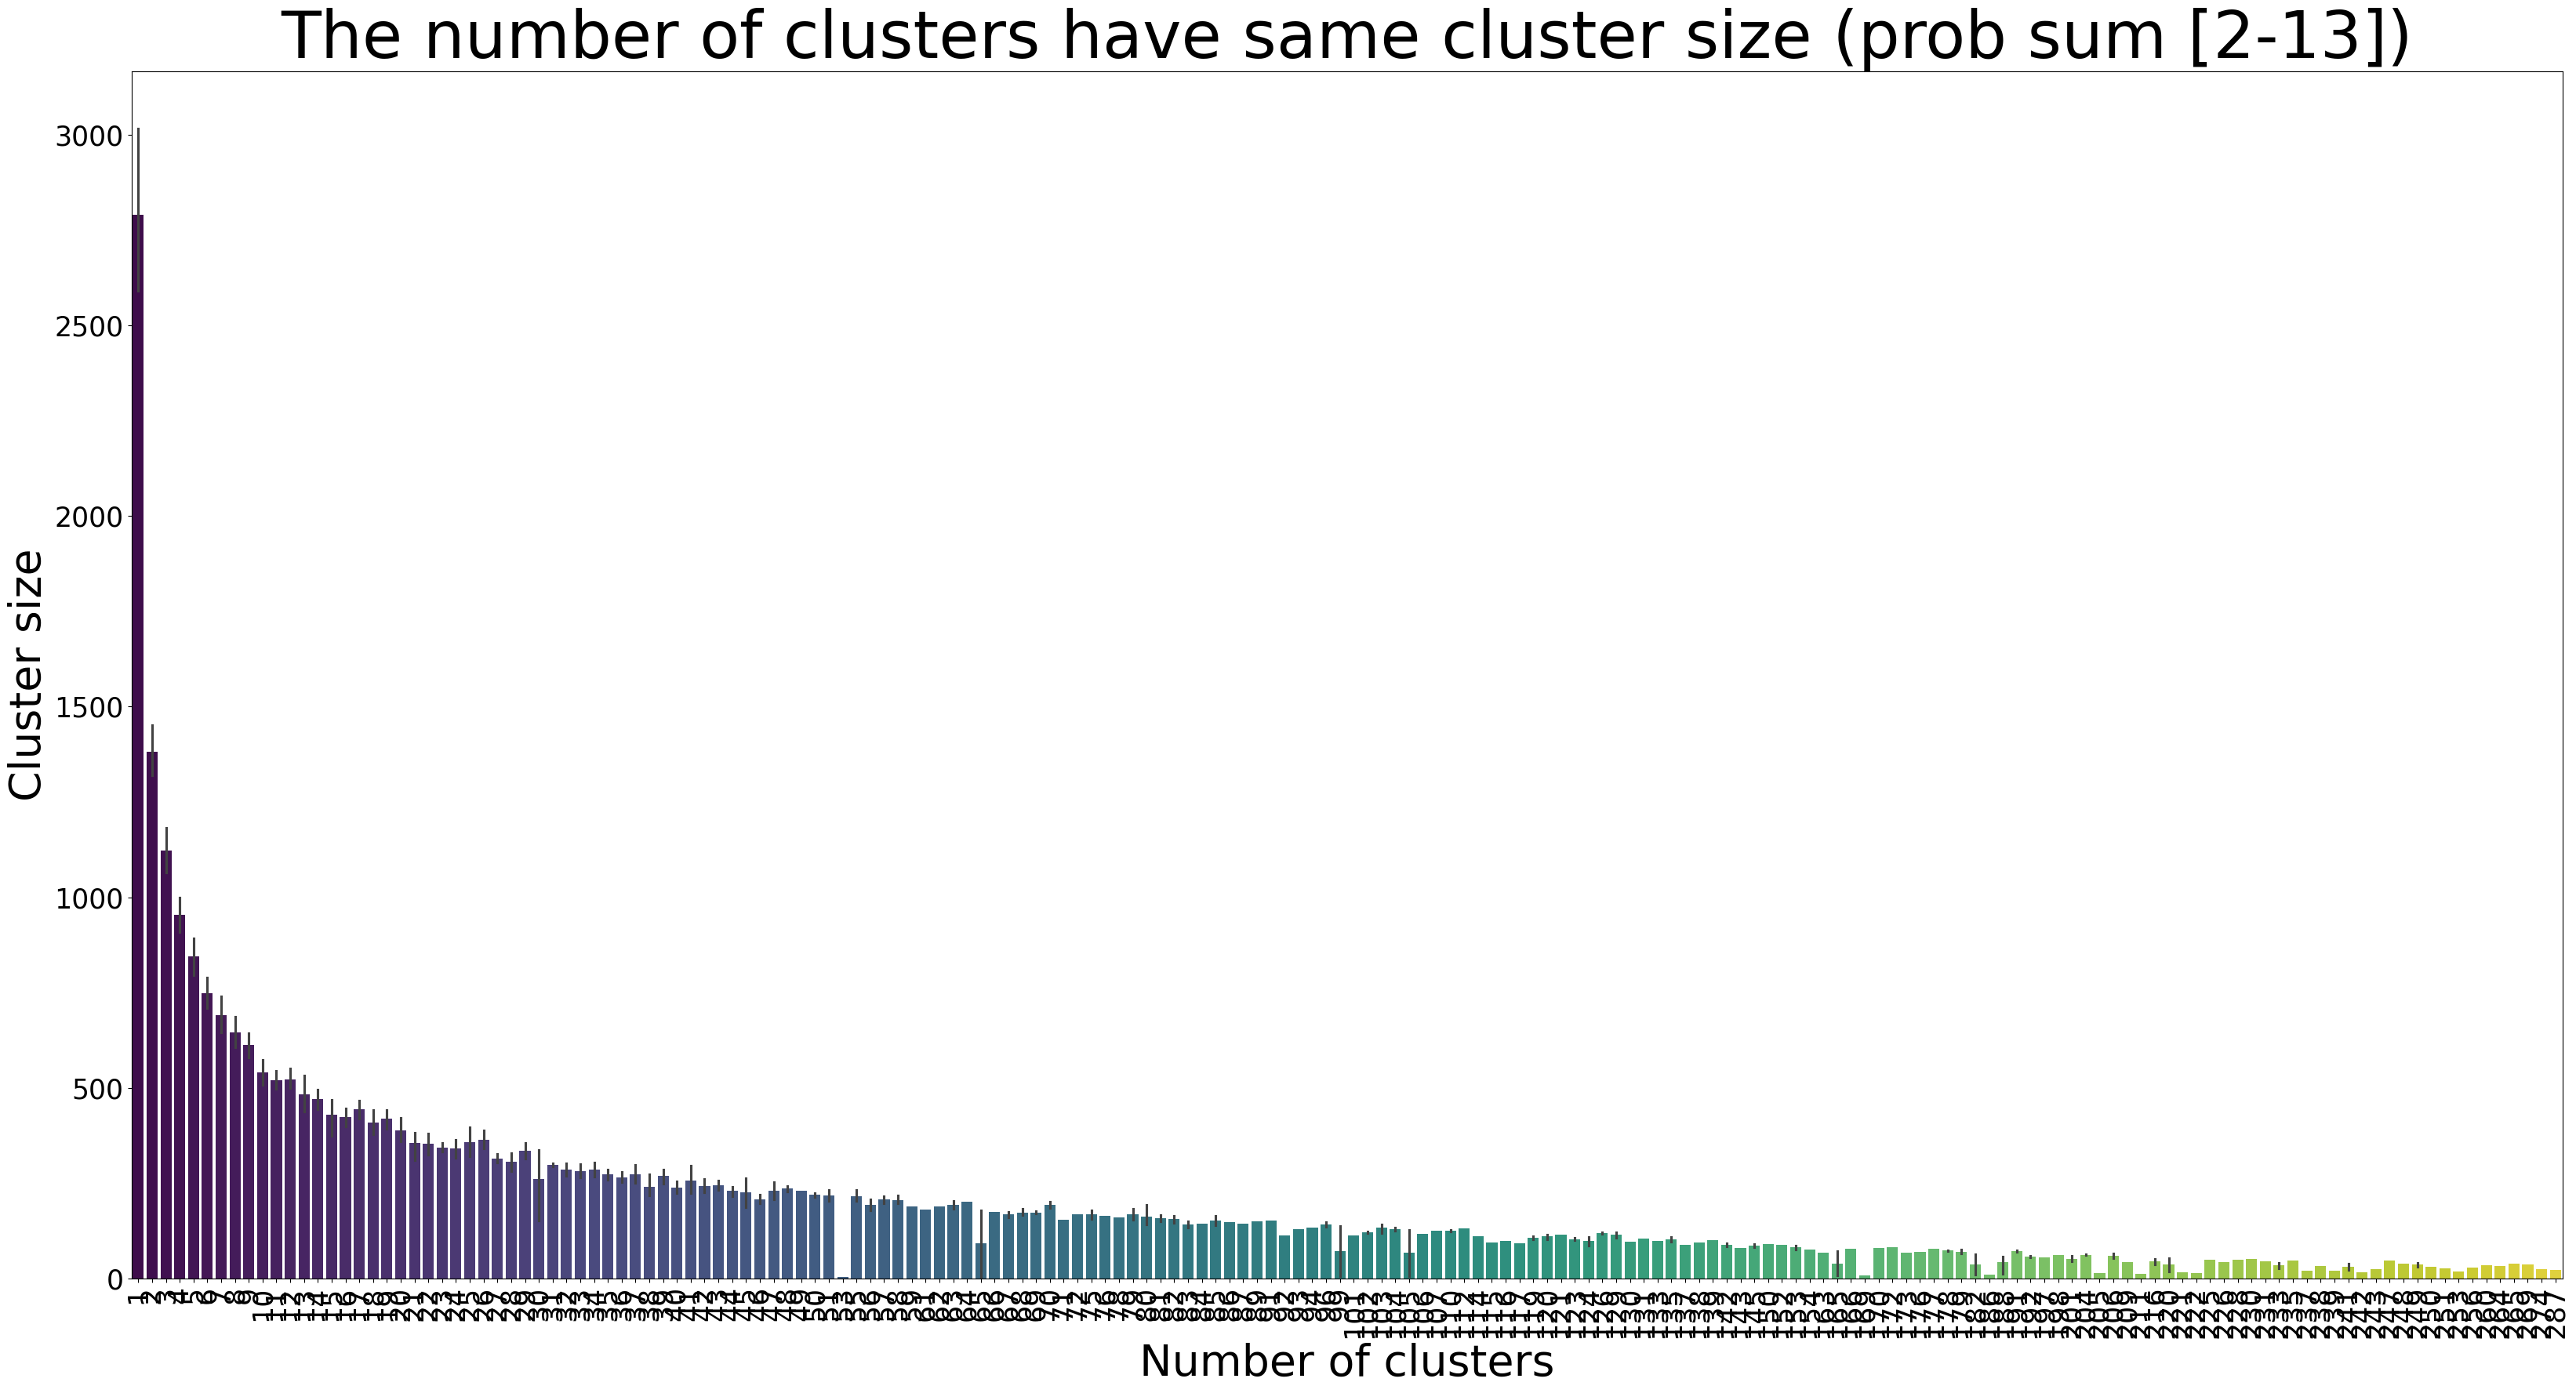

In [3]:
df = pd.read_csv(os.path.join(data_path, 'output_Aug_7_80.txt'), sep='\t', header=None)
df.columns = ['ClsID','SeqID','Score','Status']
df['seq_index'] = [int(x.split('|')[1]) for x in df.SeqID.values]
df['seq_pred_sum'] = [int(x.split('|')[2]) for x in df.SeqID.values]
print(df.shape)
display(df.head())
print(f"Total clusters={df.ClsID.nunique()}\nTotal sequences={df.SeqID.nunique()}")
df_cnt=df.groupby('ClsID').size().reset_index()
df_cnt.columns=['ClsID', 'Size']
df_cnt.sort_values('Size', ascending=False, inplace=True)
display(df_cnt.head())
df_size = df_cnt.groupby('Size')['ClsID'].apply(lambda x: len(x)).reset_index()
df_size.columns = ['Size', 'NoOfClusters']
print(df_size.Size.nunique())
display(df_size.head())
plt.figure(figsize=(40, 20))
sns.barplot(data = df_size[np.logical_and(df_size.Size>1, True)], y='Size', x='NoOfClusters', palette='viridis',)
plt.ylabel('Cluster size', fontsize=40)
plt.xlabel('Number of clusters', fontsize=40)
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.title('The number of clusters have same cluster size (prob sum [2-13])', fontsize=60)
plt.show()

# Analysis of [2-13]

In [4]:
df_tmp1 = pd.read_csv(os.path.join(data_path, 'output_Aug_7_80.txt'), sep='\t', header=None)
df_tmp1.columns = ['ClsID','SeqID','Score','Status']
df_tmp1['seq_index'] = [int(x.split('|')[1])-1 for x in df_tmp1.SeqID.values]
df_tmp1['predictions'] = [int(x.split('|')[2]) for x in df_tmp1.SeqID.values]
print(df_tmp1.shape)
display(df_tmp1.head())

(10000000, 6)


ClsID              SeqID   Score Status  seq_index  predictions
0      1   >gi|146|20|44.00  0.9032      M        145           20
1      1   >gi|175|21|52.00  0.8278      M        174           21
2      1   >gi|587|24|52.00  0.7784      E        586           24
3      1   >gi|989|11|44.00  0.8422      M        988           11
4      1  >gi|1321|22|48.00  0.8331      M       1320           22

In [5]:
df_tmp2 = pd.read_csv(os.path.join(data_path, 'gc_content_predictions.csv'))
df_tmp2.predictions = df_tmp2.predictions.astype(int)
df_tmp2['seq_index'] = df_tmp2.index

print(df_tmp2.shape)
display(df_tmp2.head())

(10000000, 4)


sequence  gc_content  predictions  seq_index
0  GTTCTATAGACATGAATGATTTGCG        0.36           17          0
1  CATTGACTAGCCCCATCCAATTGTA        0.44           19          1
2  CAGGCCTGTGGACGGCAAGTCTAGT        0.60           20          2
3  AGTTCAGACGCTATCTCTCACGATT        0.44           21          3
4  CGAAAGGTTGCGATCTCAGTTGTGC        0.52           22          4

In [6]:
data = df_tmp1.merge(df_tmp2, on=['seq_index', 'predictions'])
del [df_tmp1, df_tmp2]
data = data[['sequence', 'seq_index', 'predictions', 'gc_content', 'ClsID', 'Status', 'Score']]
print(data.shape)
#data[['sequence','predictions', 'gc_content', 'ClsID']].to_csv(os.path.join(data_path, "Cluster_for_pred_score_2_13.csv"), index=False)
display(data.head())

(935295, 7)


sequence  seq_index  predictions  gc_content  ClsID  \
0  GCCACAAAAGTCATATACCGTTAAT       3102           22        0.36      1   
1  GAGGACGAGGGATGTTTTGGTTGCG       4449           20        0.56      1   
2  AGACATTATGACAAGTAGGCACGTA       4480           16        0.40      1   
3  GCACGGCCAAATTCATCCTCATGCT       5396           20        0.52      1   
4  CGGTTCACATGCTTGGTGTAAGTCA       6093           20        0.48      1   

  Status   Score  
0      M  0.8342  
1      M  0.8337  
2      M  0.8356  
3      M  0.8095  
4      M  0.8078

In [16]:
data.ClsID.nunique()

37665

1.179612786384844 1.3458716677931755


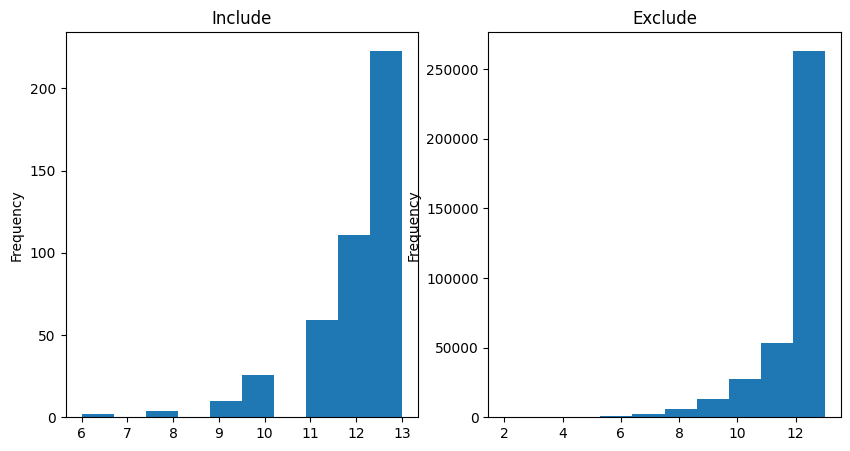

In [ ]:
tmp = data.groupby('ClsID')['predictions'].apply(lambda x: len(x)).reset_index()
print(tmp.ClsID[tmp.predictions>1].nunique())

for cid in tmp.ClsID[tmp.predictions>1]:    
    print(np.std(data.predictions[data.ClsID==cid]), np.std(data.predictions[data.ClsID!=cid]))
'''_, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2, )
data.predictions[data.ClsID==cid].plot(kind='hist', ax=ax[0], title="Include")
data.predictions[data.ClsID!=cid].plot(kind='hist', ax=ax[1], title="Exclude")
plt.show()'''

plt.figure(figsize=(20, 13))
x,y,z=[],[],[]
A=200
B=100000
for i in range(A):
    x.append(np.std(np.random.randint(low=2, high=14, size=np.random.randint(low=2, high=1867, size=1))))
    y.append(np.std(np.random.randint(low=25, high=28, size=np.random.randint(low=2, high=1867, size=1))))
    z.append(np.std(np.random.randint(low=2, high=28, size=np.random.randint(low=2, high=1867, size=1))))

plt.plot(x, label='[2-13]')
plt.plot(y, label='[25-27]')
plt.plot(z, label='[2-27]')
plt.legend()
plt.show()


tmp = data.groupby('seq_index')['ClsID'].apply(lambda x: x.nunique()).reset_index()
tmp.columns=['seq_index', 'total_clusters']
print(tmp.total_clusters.min(), tmp.total_clusters.max())
del tmp

In [14]:
def compute_out_cls_stat(df):
    if len(df)==0: return

    low = int(df['predictions'].min())
    high = int(df['predictions'].max())
    ClsID=[]
    Count=[]
    predictions_std_out=[]
    gc_content_std_out=[]
    predictions_std=[]
    gc_content_std=[]
    freq = {}
    for i in range(low, high+1):
        freq[f"{i}"]=[]
        freq[f"out_{i}"]=[]

    tmp = df.groupby('ClsID')['predictions'].apply(lambda x: len(x)).reset_index()
    tmp = tmp[tmp.predictions>1]

    print(f'Total clusters to process={tmp.ClsID.nunique()}')

    for cid in tmp.ClsID.unique():
        ClsID.append(cid)
        Count.append(df[df.ClsID==cid].shape[0])
        predictions_std_out.append(np.std(df['predictions'][df.ClsID!=cid]))
        gc_content_std_out.append(np.std(df['gc_content'][df.ClsID!=cid]))
        predictions_std.append(np.std(df['predictions'][df.ClsID==cid]))
        gc_content_std.append(np.std(df['gc_content'][df.ClsID==cid]))
        
        '''f = Counter(df['predictions'][df.ClsID==cid].values)
        for k in f:
            freq[f"{k}"].append(f[k])

        f = Counter(df['predictions'][df.ClsID!=cid].values)
        for k in f:
            freq[f"out_{k}"].append(f[k])'''

    d = {'ClsID':ClsID, 
        'predictions_std':predictions_std, 
        'predictions_std_out':predictions_std_out, 
        'gc_content_std':gc_content_std, 
        'gc_content_std_out':gc_content_std_out, 
        'Count':Count}
    
    return pd.DataFrame(d)

'''df_agg = data.groupby('ClsID').agg({
    'predictions': ['std'],#['min', 'mean', 'median', 'std', 'max'],
    'gc_content': ['std', 'count'] #['min', 'mean', 'median', 'std', 'max', 'count']
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'gc_content_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
display(df_agg.head())'''

df_agg = compute_out_cls_stat(data)
display(df_agg.head())

Total clusters to process=5406


ClsID  predictions_std  predictions_std_out  gc_content_std  \
0      1         1.321570             1.345712        0.038973   
1      2         1.179613             1.345872        0.041839   
2      3         1.226328             1.345783        0.046003   
3      4         1.301293             1.345922        0.048608   
4      5         1.367955             1.345701        0.043782   

   gc_content_std_out  Count  
0            0.127619    163  
1            0.127704    435  
2            0.127677    272  
3            0.127915   1866  
4            0.127649     78

<Figure size 2000x1200 with 0 Axes>

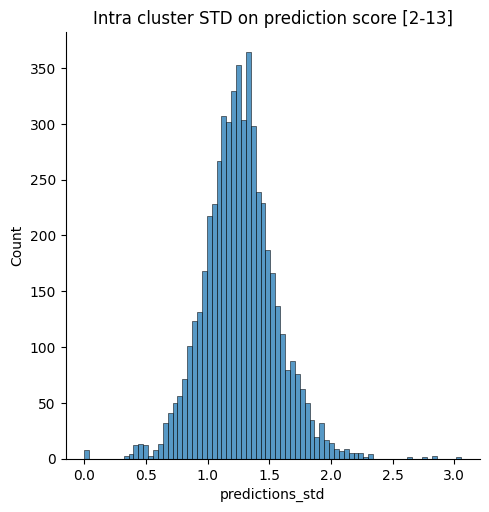

<Figure size 2000x1200 with 0 Axes>

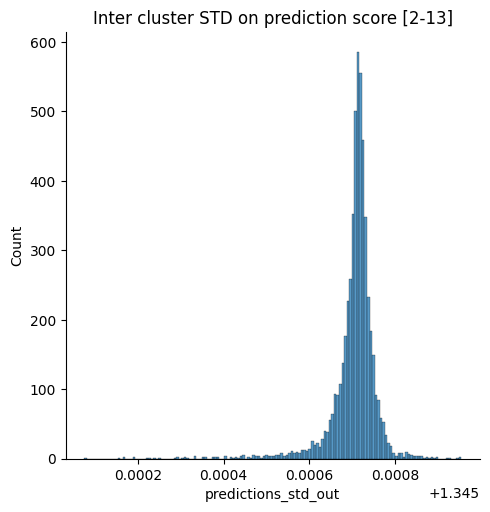

In [16]:
plt.figure(figsize=(20,12))
sns.displot(df_agg.predictions_std, kind='hist')
plt.title('Intra cluster STD on prediction score [2-13]')
plt.show()

plt.figure(figsize=(20,12))
sns.displot(df_agg.predictions_std_out, kind='hist')
plt.title('Inter cluster STD on prediction score [2-13]')
plt.show()

In [ ]:
print("Total clusters=",df_agg.ClsID.nunique())
print("Total singleton cluster=",df_agg.ClsID[df_agg.Count==1].shape[0])
print("Total non-singleton cluster=",df_agg.ClsID.nunique() - df_agg.ClsID[df_agg.Count==1].shape[0])

Total clusters= 37665
Total singleton cluster= 32259
Total non-singleton cluster= 5406


In [15]:
print("Total clusters=",df_out_agg.ClsID.nunique())
print("Total singleton cluster=",df_out_agg.ClsID[df_out_agg.Count==1].nunique())
print("Total non-singleton cluster=",df_out_agg.ClsID.nunique() - df_out_agg.ClsID[df_out_agg.Count==1].nunique())

Total clusters= 37665
Total singleton cluster= 32259
Total non-singleton cluster= 5406


In [16]:
df_cnt = df_out_agg[df_out_agg.Count>1]
print(df_cnt.shape)
df_cnt.head()

(5406, 6)


ClsID  predictions_std  predictions_std_out  gc_content_std  \
0      1         1.321570             1.345712        0.038973   
1      2         1.179613             1.345872        0.041839   
2      3         1.226328             1.345783        0.046003   
3      4         1.301293             1.345922        0.048608   
4      5         1.367955             1.345701        0.043782   

   gc_content_std_out  Count  
0            0.127619    163  
1            0.127704    435  
2            0.127677    272  
3            0.127915   1866  
4            0.127649     78

In [19]:
print(df_out_agg.predictions_std.min(),
df_out_agg.predictions_std.max(),
df_out_agg.predictions_std_out.min(),
df_out_agg.predictions_std_out.max())

0.0 3.0572763655760995 1.3450746870987174 1.3459550051741442


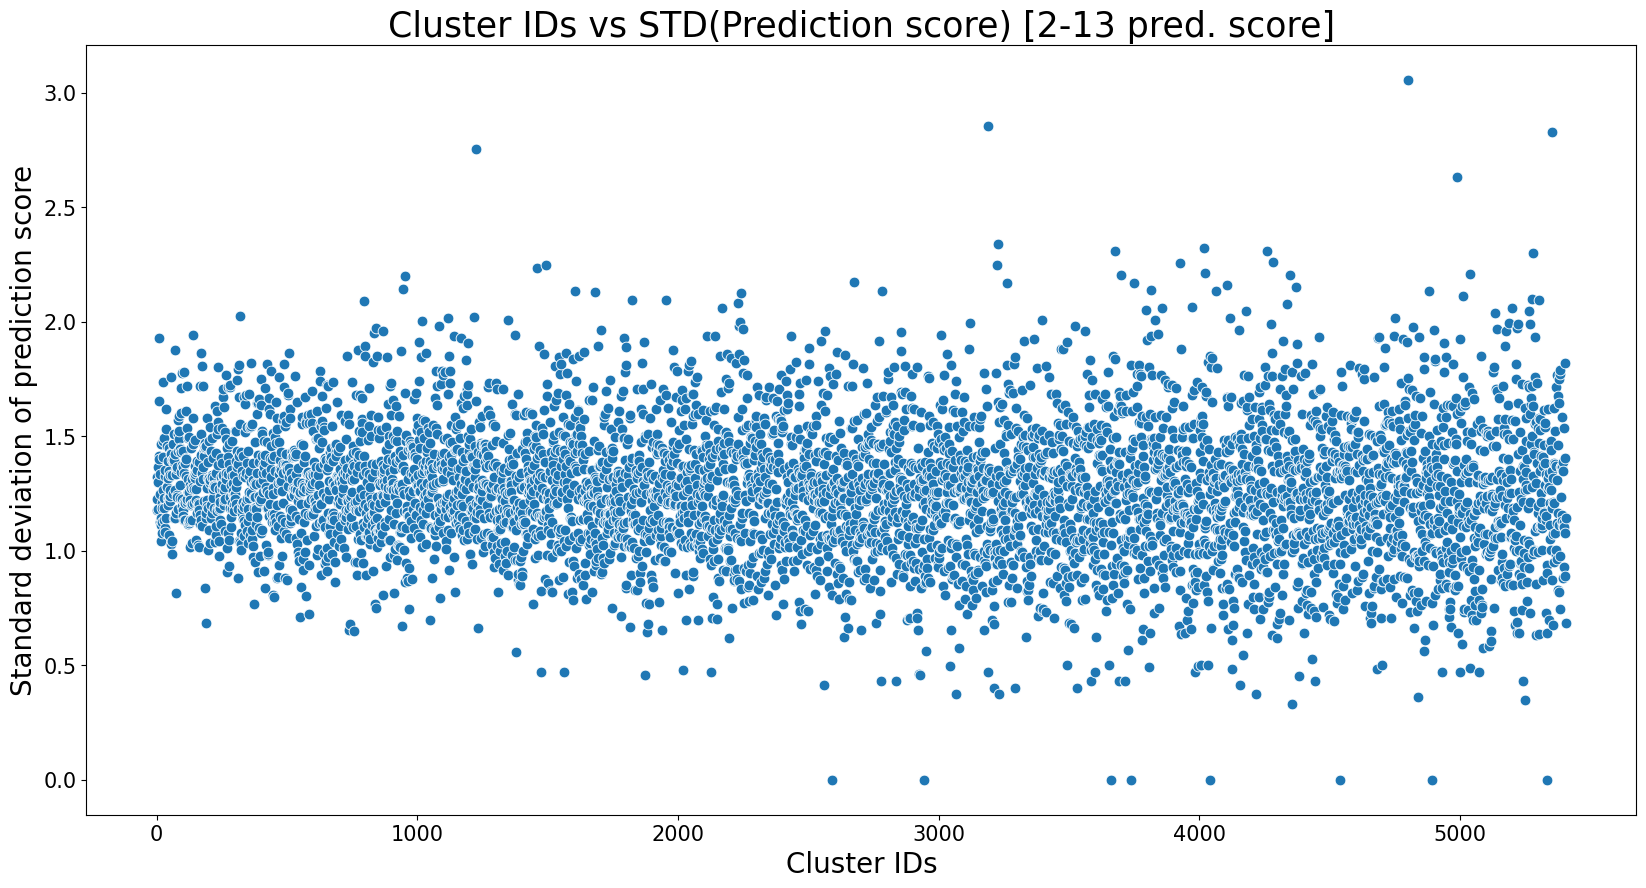

In [17]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.ClsID, y=df_cnt.predictions_std, s=60)
plt.xlabel('Cluster IDs', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of prediction score', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Cluster IDs vs STD(Prediction score) [2-13 pred. score]', fontsize=25)
plt.show()

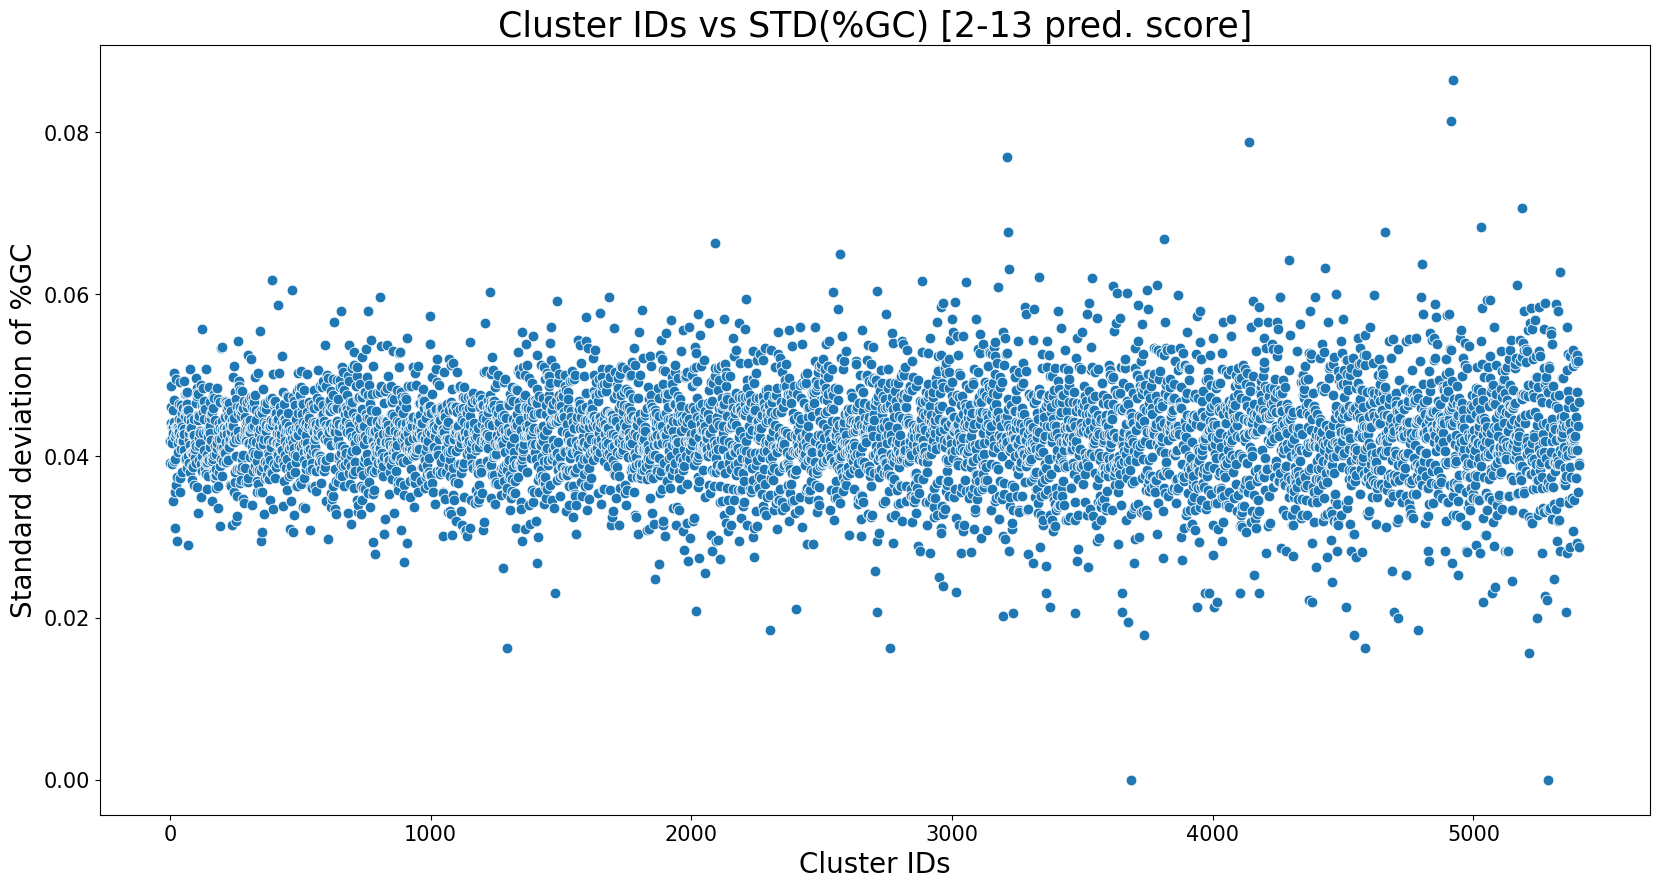

In [52]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.ClsID, y=df_cnt.gc_content_std, s=60)
plt.xlabel('Cluster IDs', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of %GC', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Cluster IDs vs STD(%GC) [2-13 pred. score]', fontsize=25)
plt.show()

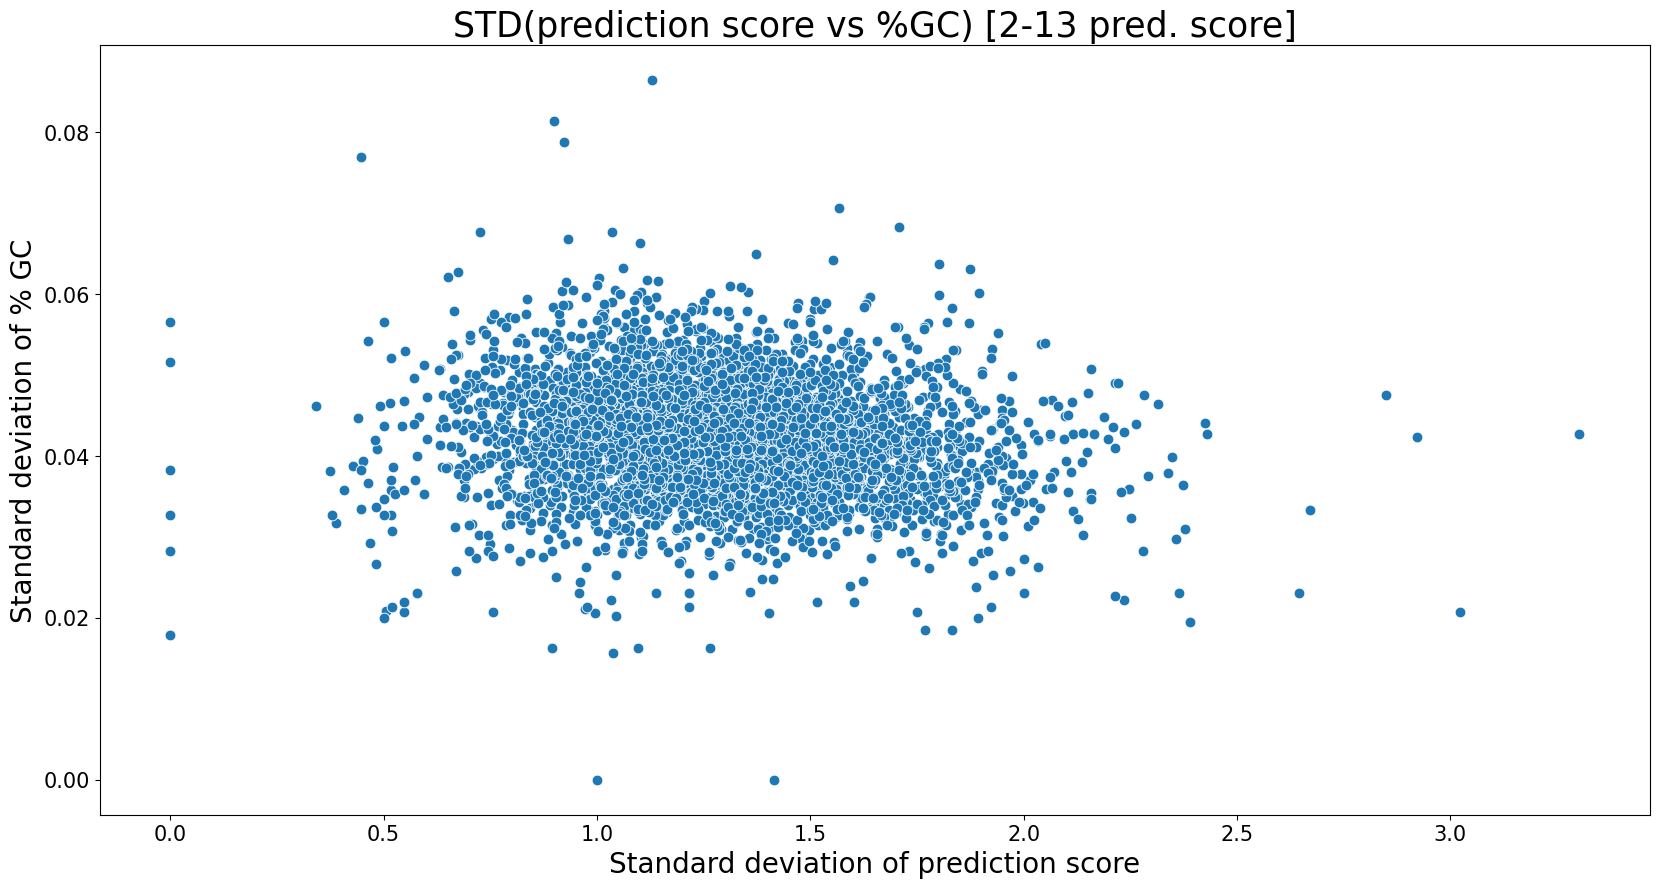

In [53]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.predictions_std, y=df_cnt.gc_content_std, s=60)
plt.xlabel('Standard deviation of prediction score', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of % GC', fontsize=20)
plt.yticks(fontsize=15)
plt.title('STD(prediction score vs %GC) [2-13 pred. score]', fontsize=25)
plt.show()

# Cluster distribution [25-27]

(319725, 6)


ClsID       SeqID   Score Status  seq_index  seq_pred_sum
0      1   >M5200:26  0.9713      C       5200            26
1      1  >M12339:25  0.8311      M      12339            25
2      1  >M12479:25  0.8275      M      12479            25
3      1  >M12851:25  0.8380      M      12851            25
4      1  >M17214:25  0.8333      M      17214            25

Total clusters=37016
Total sequences=319725


ClsID  Size
0       1  2163
1       2  1491
55     56  1056
12     13   993
18     19   926

320


Size  NoOfClusters
0     1         32015
1     2             3
2     3            14
3     4            18
4     5            22

/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_69377/1590362425.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_size[np.logical_and(df_size.Size>1, df_size.Size<1000)], y='Size', x='NoOfClusters', palette='viridis',)


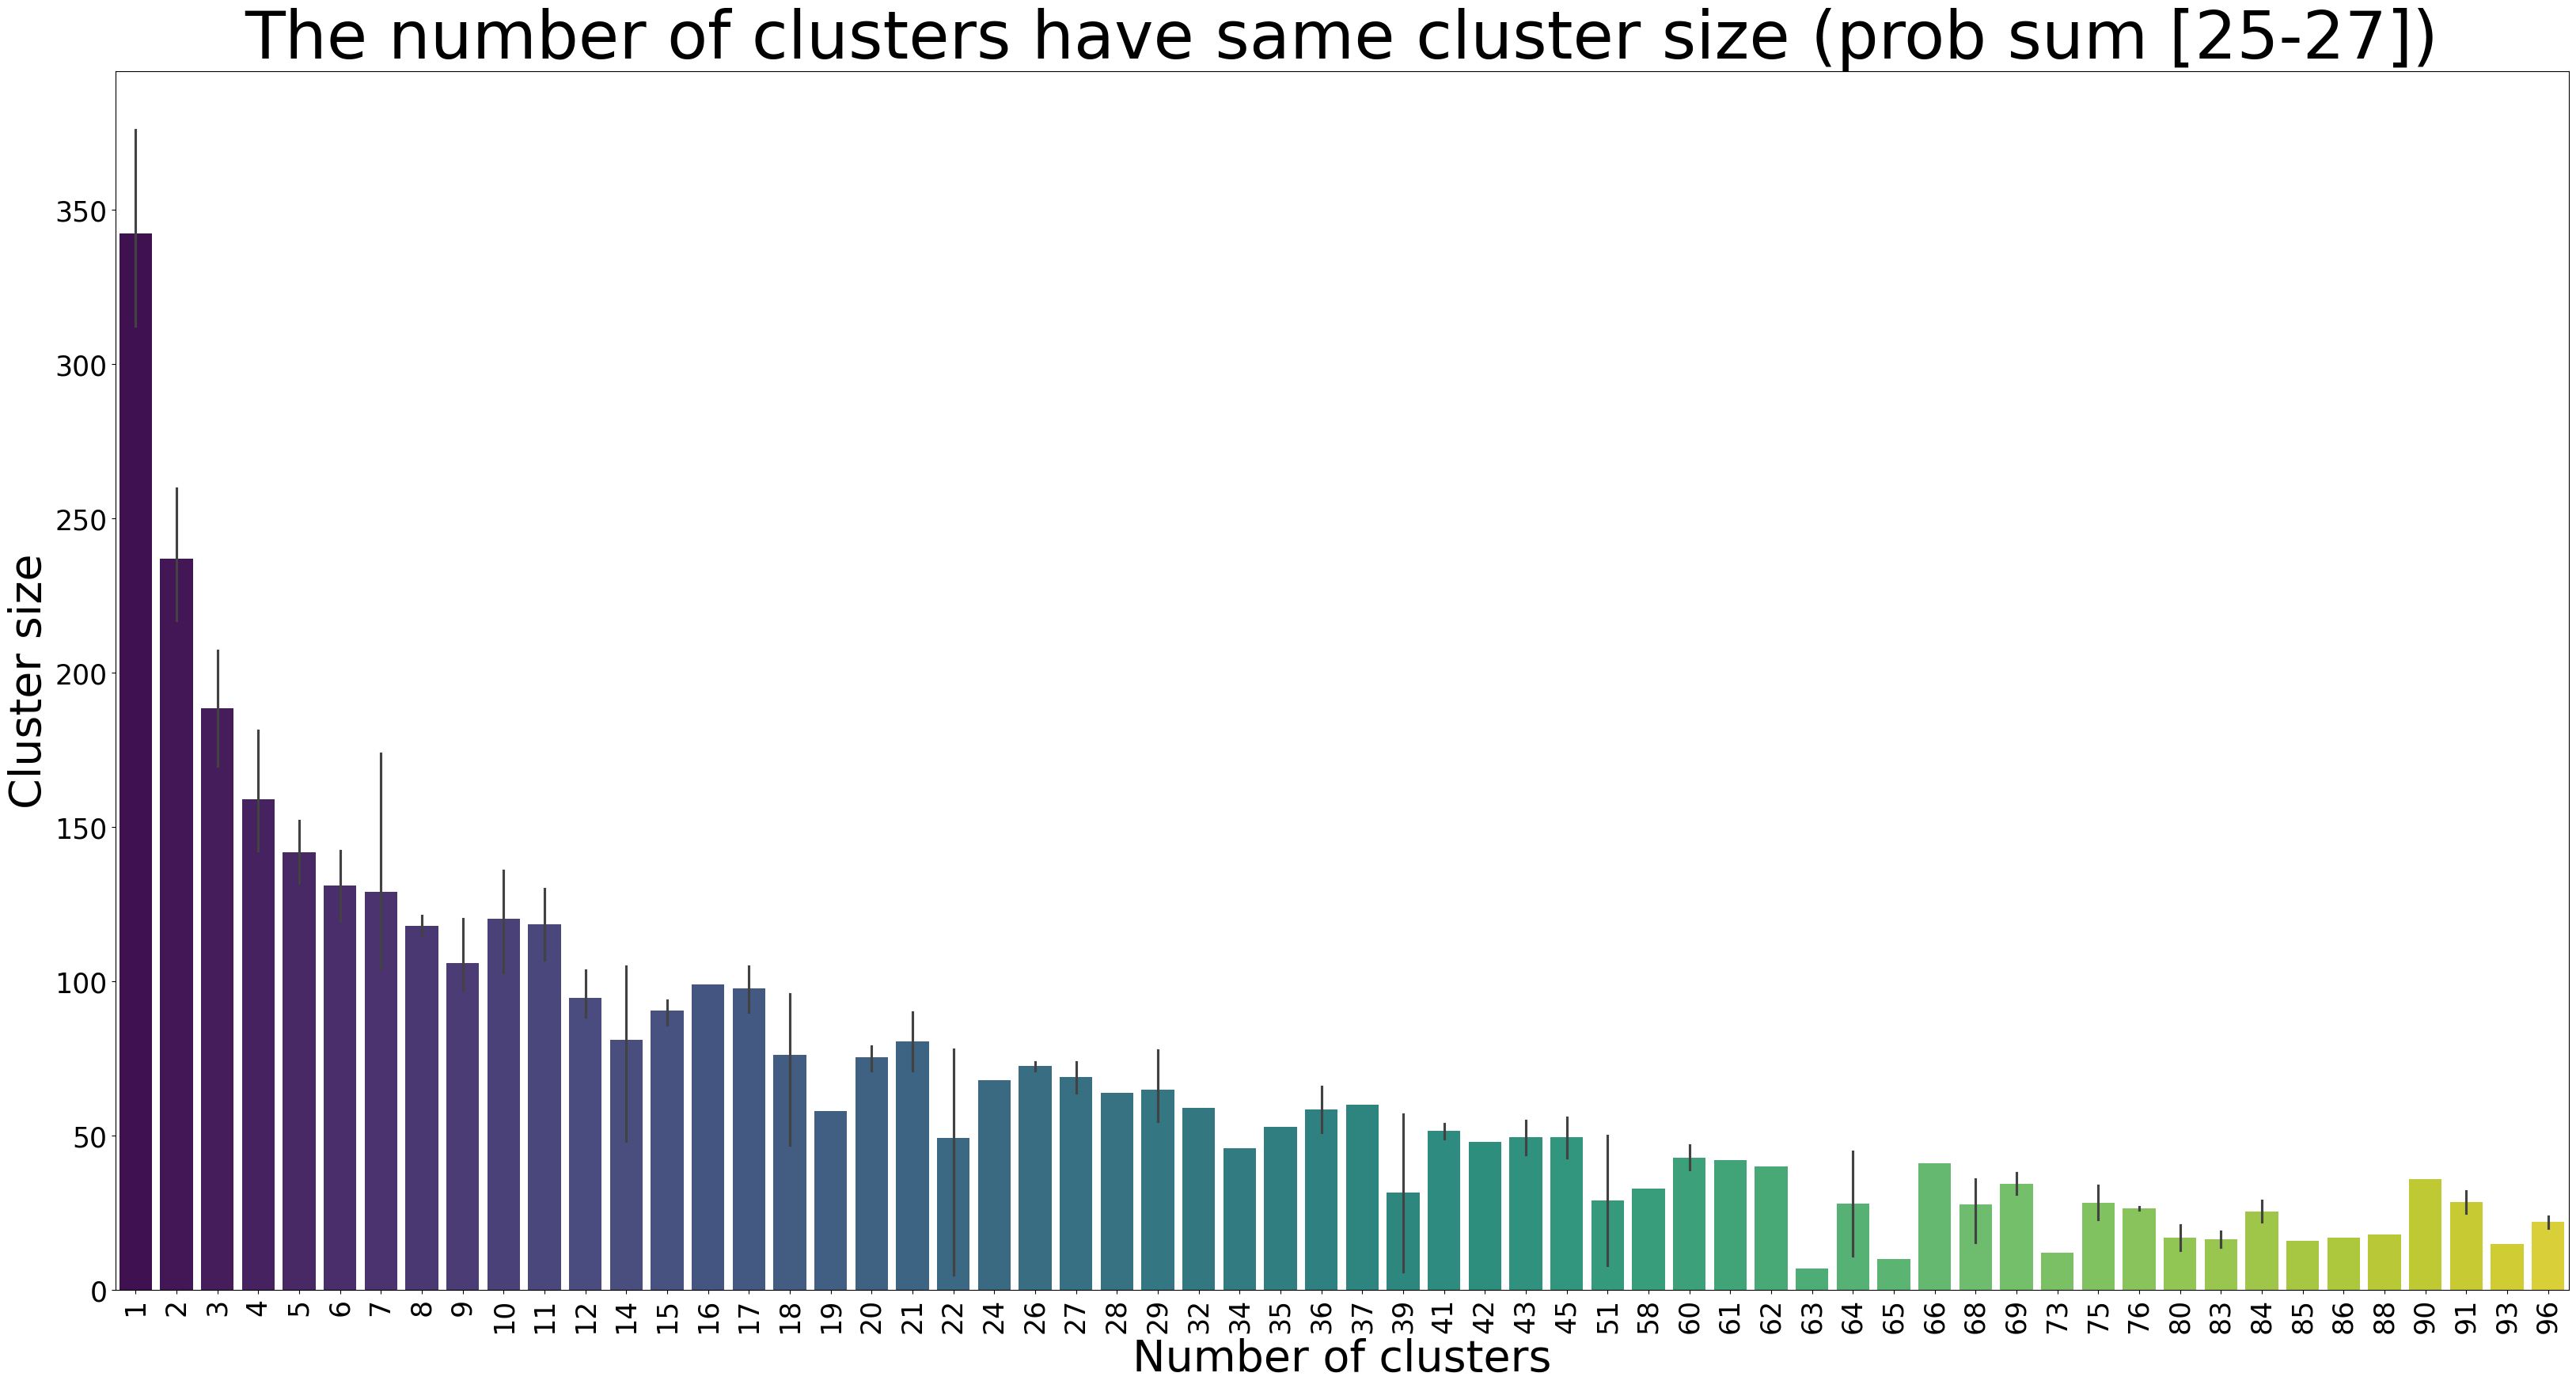

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'output_Aug_01_25_27_80.txt'), sep='\t', header=None)
df.columns = ['ClsID','SeqID','Score','Status']
df['seq_index'] = [int(x.split(':')[0][2:]) for x in df.SeqID.values]
df['seq_pred_sum'] = [int(x.split(':')[1]) for x in df.SeqID.values]
print(df.shape)
display(df.head())
print(f"Total clusters={df.ClsID.nunique()}\nTotal sequences={df.SeqID.nunique()}")
df_cnt=df.groupby('ClsID').size().reset_index()
df_cnt.columns=['ClsID', 'Size']
df_cnt.sort_values('Size', ascending=False, inplace=True)
display(df_cnt.head())
df_size = df_cnt.groupby('Size')['ClsID'].apply(lambda x: len(x)).reset_index()
df_size.columns = ['Size', 'NoOfClusters']
print(df_size.Size.nunique())
display(df_size.head())
plt.figure(figsize=(40, 20))
sns.barplot(data = df_size[np.logical_and(df_size.Size>1, df_size.Size<1000)], y='Size', x='NoOfClusters', palette='viridis',)
plt.ylabel('Cluster size', fontsize=40)
plt.xlabel('Number of clusters', fontsize=40)
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.title('The number of clusters have same cluster size (prob sum [25-27])', fontsize=60)
plt.show()

# Analysis [25-27]

In [17]:
df_tmp1 = pd.read_csv(os.path.join(cls_data_path, 'output_Aug_01_25_27_80.txt'), sep='\t', header=None)
df_tmp1.columns = ['ClsID','SeqID','Score','Status']
df_tmp1['seq_index'] = [int(x.split(':')[0][2:])-1 for x in df_tmp1.SeqID.values]
df_tmp1['predictions'] = [int(x.split(':')[1]) for x in df_tmp1.SeqID.values]
print(df_tmp1.shape)
display(df_tmp1.head())

(319725, 6)


ClsID       SeqID   Score Status  seq_index  predictions
0      1   >M5200:26  0.9713      C       5199           26
1      1  >M12339:25  0.8311      M      12338           25
2      1  >M12479:25  0.8275      M      12478           25
3      1  >M12851:25  0.8380      M      12850           25
4      1  >M17214:25  0.8333      M      17213           25

In [18]:
df_tmp2 = pd.read_csv(os.path.join(data_path, 'gc_content_predictions.csv'))
df_tmp2.predictions = df_tmp2.predictions.astype(int)
df_tmp2['seq_index'] = df_tmp2.index

print(df_tmp2.shape)
display(df_tmp2.head())

(10000000, 4)


sequence  gc_content  predictions  seq_index
0  GTTCTATAGACATGAATGATTTGCG        0.36           17          0
1  CATTGACTAGCCCCATCCAATTGTA        0.44           19          1
2  CAGGCCTGTGGACGGCAAGTCTAGT        0.60           20          2
3  AGTTCAGACGCTATCTCTCACGATT        0.44           21          3
4  CGAAAGGTTGCGATCTCAGTTGTGC        0.52           22          4

In [19]:
data = df_tmp1.merge(df_tmp2, on=['seq_index', 'predictions'])
del [df_tmp1, df_tmp2]
data = data[['sequence', 'seq_index', 'predictions', 'gc_content', 'ClsID', 'Status', 'Score']]
print(data.shape)
#data[['sequence','predictions', 'gc_content', 'ClsID']].to_csv(os.path.join(data_path, "Cluster_for_pred_score_25_27.csv"), index=False)
display(data.head())

(319725, 7)


sequence  seq_index  predictions  gc_content  ClsID  \
0  ACAGCGTATTCCTGGCGTAGAACGG       5199           26        0.56      1   
1  CGCACAATACGTTAGTCTCGGTGAG      12338           25        0.52      1   
2  ATCCGCAGTAGTGGTAATTACGCGA      12478           25        0.48      1   
3  GCGTCCGTACCACCTGGCAAGATTA      12850           25        0.56      1   
4  CGGTAGCCACCGAGCGTCTTGAACA      17213           25        0.60      1   

  Status   Score  
0      C  0.9713  
1      M  0.8311  
2      M  0.8275  
3      M  0.8380  
4      M  0.8333

In [65]:
# Any sequence belongs to multiple cluster?
tmp = data.groupby('seq_index')['ClsID'].apply(lambda x: x.nunique()).reset_index()
tmp.columns=['seq_index', 'total_clusters']
print(tmp.total_clusters.min(), tmp.total_clusters.max())
del tmp

1 1


In [20]:
def compute_out_cls_stat(df):
    if len(df)==0: return

    low = int(df['predictions'].min())
    high = int(df['predictions'].max())
    ClsID=[]
    Count=[]
    predictions_std_out=[]
    gc_content_std_out=[]
    predictions_std=[]
    gc_content_std=[]
    freq = {}
    for i in range(low, high+1):
        freq[f"{i}"]=[]
        freq[f"out_{i}"]=[]

    tmp = df.groupby('ClsID')['predictions'].apply(lambda x: len(x)).reset_index()
    tmp = tmp[tmp.predictions>1]

    print(f'Total clusters to process={tmp.ClsID.nunique()}')

    for cid in tmp.ClsID.unique():
        ClsID.append(cid)
        Count.append(df[df.ClsID==cid].shape[0])
        predictions_std_out.append(np.std(df['predictions'][df.ClsID!=cid]))
        gc_content_std_out.append(np.std(df['gc_content'][df.ClsID!=cid]))
        predictions_std.append(np.std(df['predictions'][df.ClsID==cid]))
        gc_content_std.append(np.std(df['gc_content'][df.ClsID==cid]))
        
        '''f = Counter(df['predictions'][df.ClsID==cid].values)
        for k in f:
            freq[f"{k}"].append(f[k])

        f = Counter(df['predictions'][df.ClsID!=cid].values)
        for k in f:
            freq[f"out_{k}"].append(f[k])'''

    d = {'ClsID':ClsID, 
        'predictions_std':predictions_std, 
        'predictions_std_out':predictions_std_out, 
        'gc_content_std':gc_content_std, 
        'gc_content_std_out':gc_content_std_out, 
        'Count':Count}
    
    return pd.DataFrame(d)

'''df_agg = data.groupby('ClsID').agg({
    'predictions': ['std'],#['min', 'mean', 'median', 'std', 'max'],
    'gc_content': ['std', 'count'] #['min', 'mean', 'median', 'std', 'max', 'count']
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'gc_content_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
display(df_agg.head())'''

df_agg= compute_out_cls_stat(data)
display(df_agg.head())

Total clusters to process=5001


ClsID  predictions_std  predictions_std_out  gc_content_std  \
0      1         0.563541             0.525942        0.043227   
1      2         0.505524             0.526309        0.045642   
2      3         0.574078             0.526212        0.041461   
3      4         0.654040             0.526191        0.042031   
4      5         0.537052             0.526214        0.044826   

   gc_content_std_out  Count  
0            0.085914   2163  
1            0.085869   1491  
2            0.085732     41  
3            0.085757     55  
4            0.085752    127

<Figure size 2000x1200 with 0 Axes>

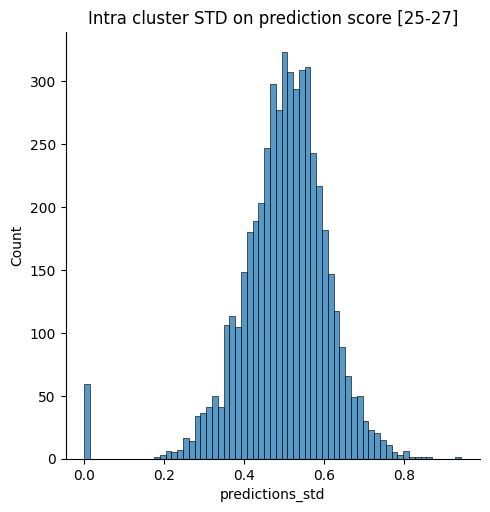

<Figure size 2000x1200 with 0 Axes>

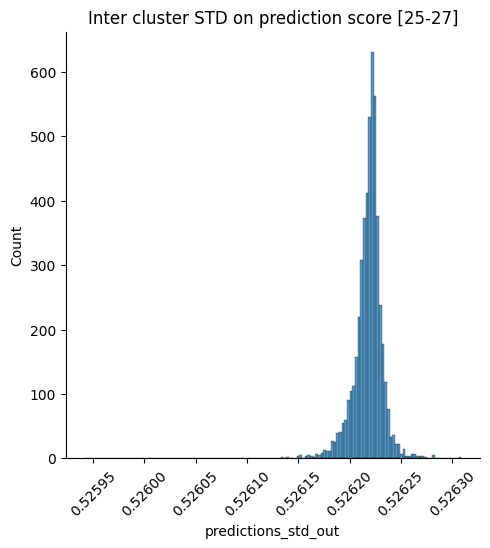

In [22]:
plt.figure(figsize=(20,12))
sns.displot(df_agg.predictions_std, kind='hist')
plt.title('Intra cluster STD on prediction score [25-27]')
plt.show()

plt.figure(figsize=(20,12))
sns.displot(df_agg.predictions_std_out, kind='hist')
plt.title('Inter cluster STD on prediction score [25-27]')
plt.xticks(rotation=45)
plt.show()

In [66]:
df_agg = data.groupby('ClsID').agg({
    'predictions': ['min', 'mean', 'median', 'std', 'max'],
    'gc_content': ['min', 'mean', 'median', 'std', 'max', 'count']
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'gc_content_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
df_agg.head()

ClsID  predictions_min  predictions_mean  predictions_median  \
0      1               25         25.339344                25.0   
1      2               25         25.260228                25.0   
2      3               25         25.365854                25.0   
3      4               25         25.436364                25.0   
4      5               25         25.299213                25.0   

   predictions_std  predictions_max  gc_content_min  gc_content_mean  \
0         0.563671               27            0.40         0.547332   
1         0.505693               27            0.36         0.478632   
2         0.581210               27            0.24         0.330732   
3         0.660068               27            0.44         0.534545   
4         0.539179               27            0.32         0.437480   

   gc_content_median  gc_content_std  gc_content_max  Count  
0               0.56        0.043237            0.68   2163  
1               0.48        0.045657            0.60   1491  
2               0.32        0.041976            0.44     41  
3               0.52        0.042418            0.64     55  
4               0.44        0.045004            0.52    127

In [67]:
print("Total clusters=",df_agg.ClsID.nunique())
print("Total singleton cluster=",df_agg.ClsID[df_agg.Count==1].shape[0])
print("Total non-singleton cluster=",df_agg.ClsID.nunique() - df_agg.ClsID[df_agg.Count==1].shape[0])

Total clusters= 37016
Total singleton cluster= 32015
Total non-singleton cluster= 5001


In [68]:
df_cnt = df_agg[df_agg.Count>1]
print(df_cnt.shape)
df_cnt.head()

(5001, 12)


ClsID  predictions_min  predictions_mean  predictions_median  \
0      1               25         25.339344                25.0   
1      2               25         25.260228                25.0   
2      3               25         25.365854                25.0   
3      4               25         25.436364                25.0   
4      5               25         25.299213                25.0   

   predictions_std  predictions_max  gc_content_min  gc_content_mean  \
0         0.563671               27            0.40         0.547332   
1         0.505693               27            0.36         0.478632   
2         0.581210               27            0.24         0.330732   
3         0.660068               27            0.44         0.534545   
4         0.539179               27            0.32         0.437480   

   gc_content_median  gc_content_std  gc_content_max  Count  
0               0.56        0.043237            0.68   2163  
1               0.48        0.045657            0.60   1491  
2               0.32        0.041976            0.44     41  
3               0.52        0.042418            0.64     55  
4               0.44        0.045004            0.52    127

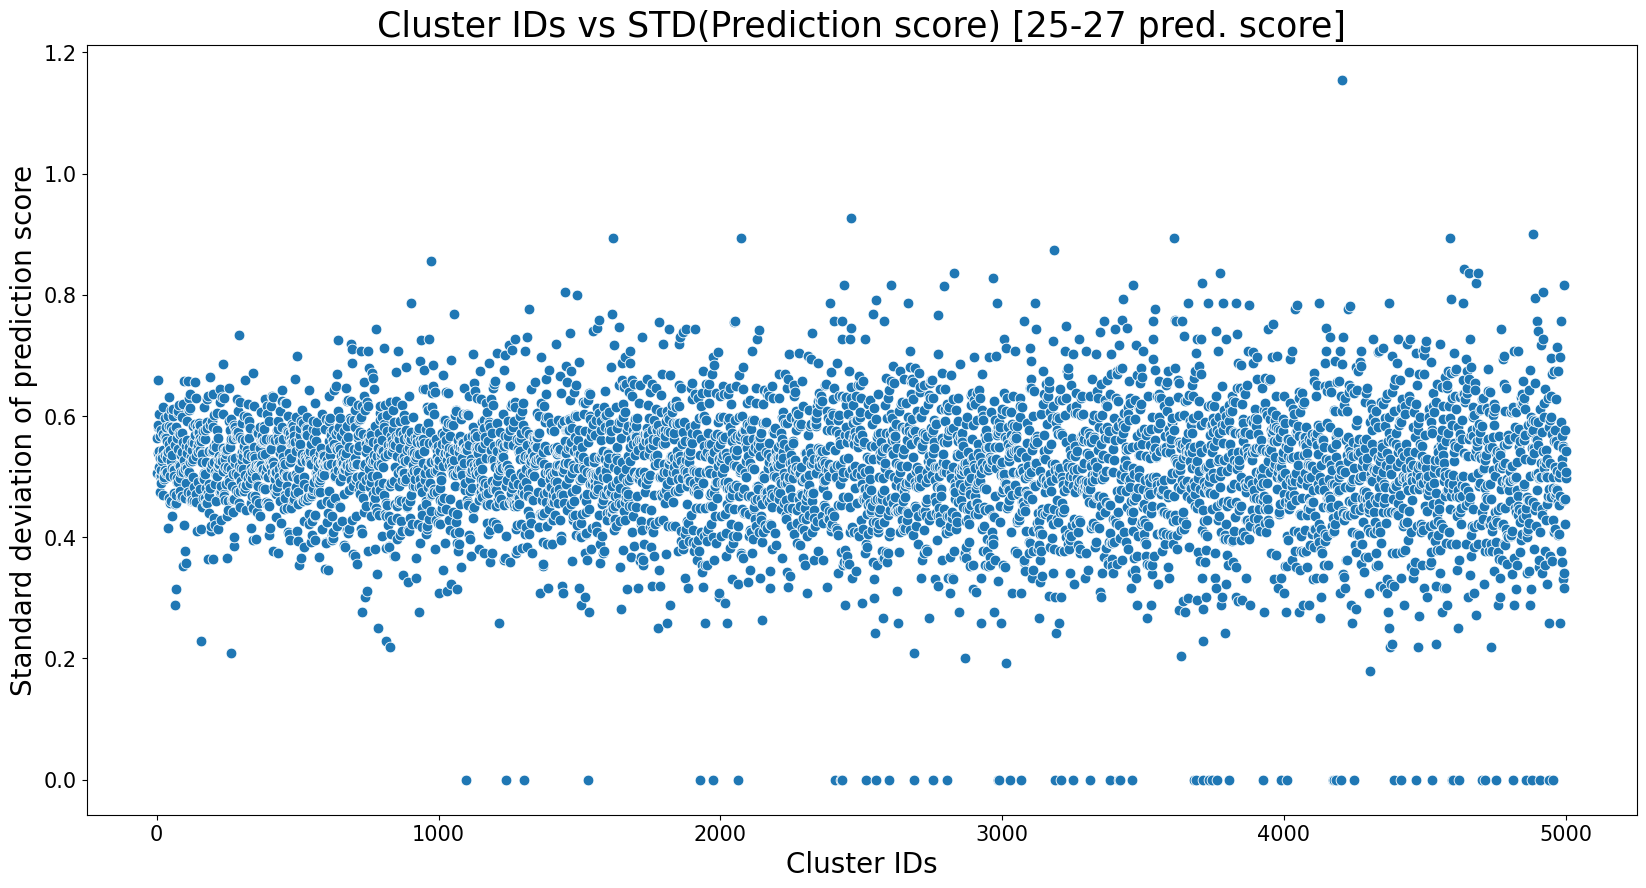

In [69]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.ClsID, y=df_cnt.predictions_std, s=60)
plt.xlabel('Cluster IDs', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of prediction score', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Cluster IDs vs STD(Prediction score) [25-27 pred. score]', fontsize=25)
plt.show()

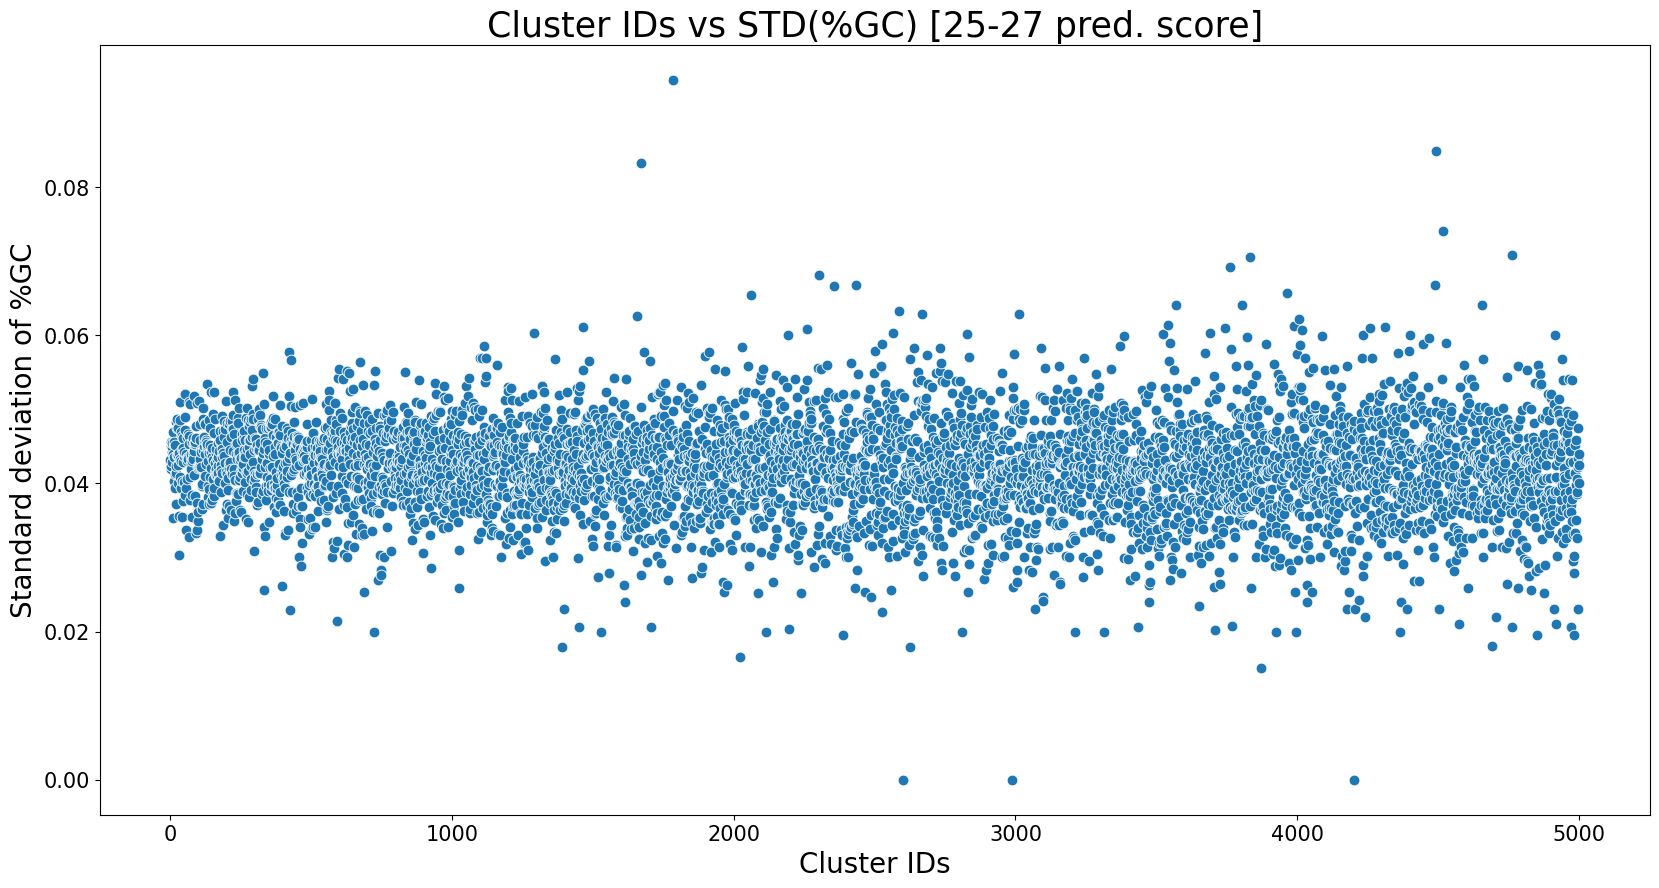

In [70]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.ClsID, y=df_cnt.gc_content_std, s=60)
plt.xlabel('Cluster IDs', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of %GC', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Cluster IDs vs STD(%GC) [25-27 pred. score]', fontsize=25)
plt.show()

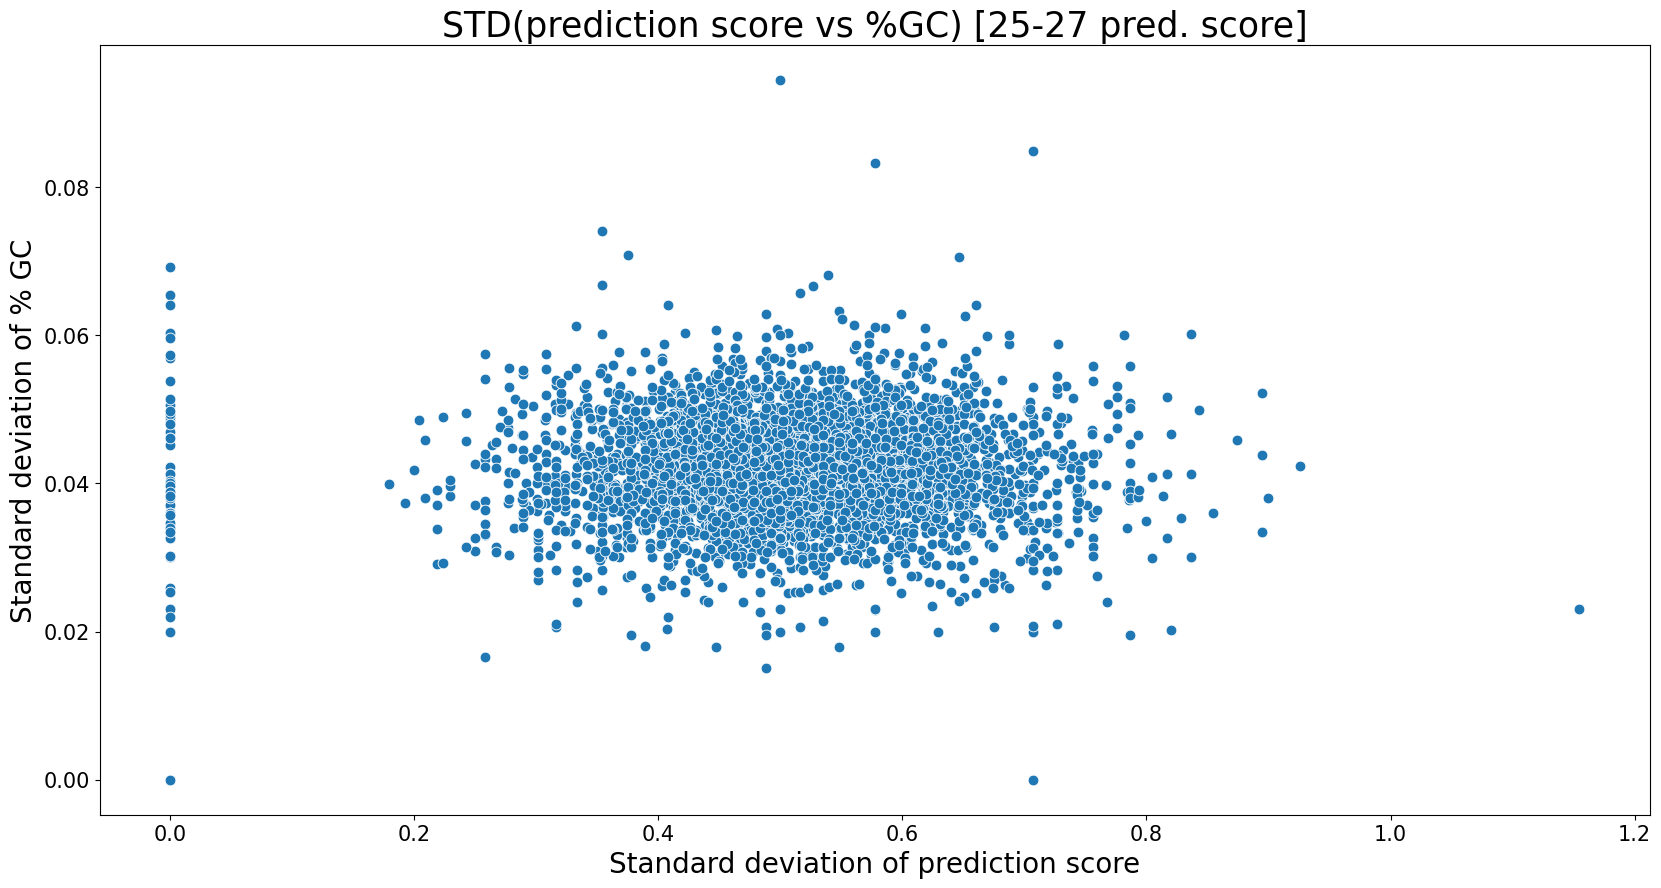

In [71]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.predictions_std, y=df_cnt.gc_content_std, s=60)
plt.xlabel('Standard deviation of prediction score', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of % GC', fontsize=20)
plt.yticks(fontsize=15)
plt.title('STD(prediction score vs %GC) [25-27 pred. score]', fontsize=25)
plt.show()

# Cluster distrobution (Whole)

(10000000, 5) 0 9999999


ClsID              SeqID   Score Status  seq_index
0      1   >gi|146|20|44.00  0.9032      M        146
1      1   >gi|175|21|52.00  0.8278      M        175
2      1   >gi|587|24|52.00  0.7784      E        587
3      1   >gi|989|11|44.00  0.8422      M        989
4      1  >gi|1321|22|48.00  0.8331      M       1321

Total clusters=55633
Total sequences=10000000


ClsID   Size
0        1  51689
1        2  47435
9       10  18088
100    101  13764
275    276  12118

2116


Size  NoOfClusters
0     1         15952
1     2            15
2     3            30
3     4            53
4     5            65

/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_35580/478590979.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_size[np.logical_and(df_size.Size>1, df_size.Size<15000)], y='Size', x='NoOfClusters', palette='viridis',)


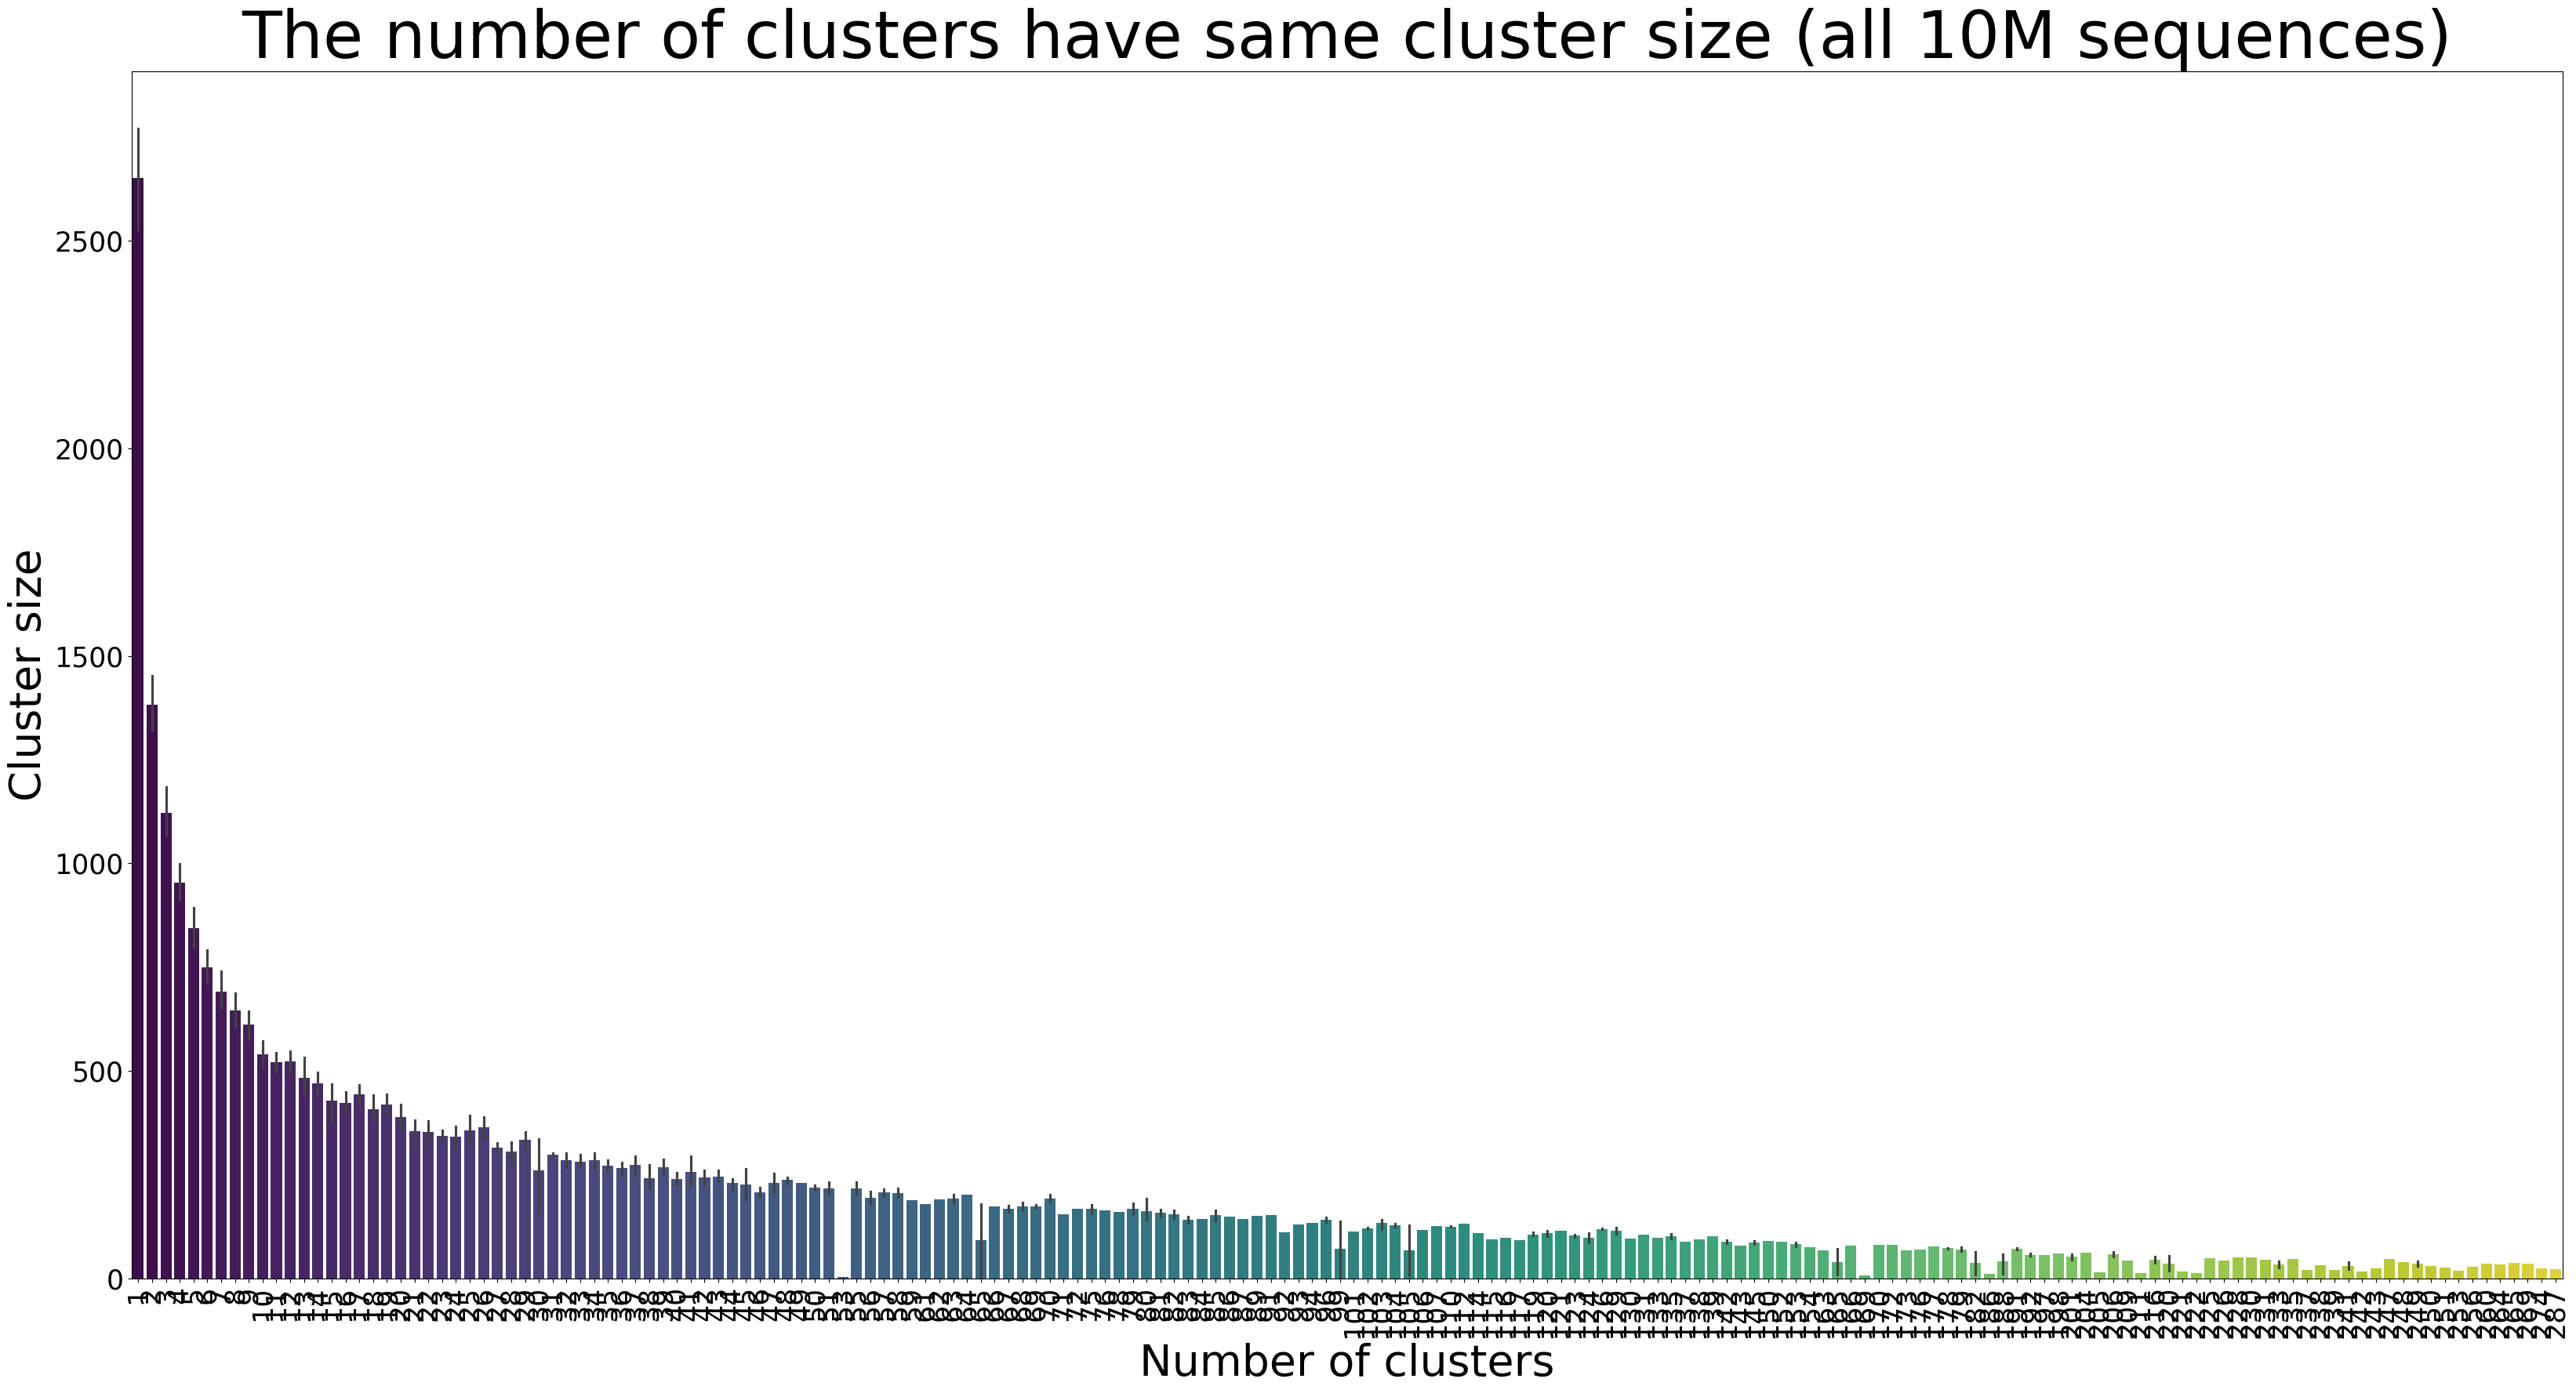

In [3]:
df = pd.read_csv(os.path.join(data_path, 'output_Aug_7_80.txt'), sep='\t', header=None)
df.columns = ['ClsID','SeqID','Score','Status']
df['seq_index'] = [int(x.split('|')[1]) for x in df.SeqID.values]
print(df.shape, df['seq_index'].min(), df['seq_index'].max())
display(df.head())
print(f"Total clusters={df.ClsID.nunique()}\nTotal sequences={df.SeqID.nunique()}")
df_cnt=df.groupby('ClsID').size().reset_index()
df_cnt.columns=['ClsID', 'Size']
df_cnt.sort_values('Size', ascending=False, inplace=True)
display(df_cnt.head())
df_size = df_cnt.groupby('Size')['ClsID'].apply(lambda x: len(x)).reset_index()
df_size.columns = ['Size', 'NoOfClusters']
print(df_size.Size.nunique())
display(df_size.head())
plt.figure(figsize=(40, 20))
sns.barplot(data = df_size[np.logical_and(df_size.Size>1, df_size.Size<15000)], y='Size', x='NoOfClusters', palette='viridis',)
plt.ylabel('Cluster size', fontsize=40)
plt.xlabel('Number of clusters', fontsize=40)
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.title('The number of clusters have same cluster size (all 10M sequences)', fontsize=60)
plt.show()

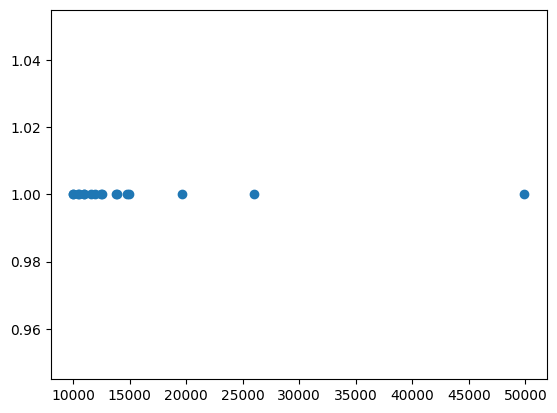

In [73]:
plt.scatter(df_size[df_size.Size>10000].Size, df_size[df_size.Size>10000].NoOfClusters)
plt.show()

# Analysis (Whole)

In [2]:
df_cluster = pd.read_csv(os.path.join(data_path, 'output_Aug_26_80.txt'), sep='\t', header=None)
df_cluster.columns = ['ClsID','SeqID','Score','Status']
df_cluster['seq_index'] = [int(x.split('|')[1]) for x in df_cluster.SeqID.values]
df_cluster = df_cluster[['ClsID', 'Status', 'seq_index']]

df_raw = pd.read_csv(os.path.join(data_path, 'random_25mers_10M.csv'))
df_raw.columns = ['sequence', 'seq_index']

df_score = pd.read_csv(os.path.join(data_path, 'gc_content_predictions_no_cao2021.csv'))

df_raw_score = df_raw.merge(df_score, on=['sequence'], how='inner')
del [df_raw, df_score]

data = df_raw_score.merge(df_cluster, on=['seq_index'])
del [df_raw_score, df_cluster]
data['prediction_score'] = data['prediction_score'].astype(int)

print(data.ClsID.nunique())
print(data.shape)
display(data.sample(10))


79797
(10000000, 6)


sequence  seq_index  gc_content  prediction_score  \
7375812  CGCAACCCGATTTACCTTCTTATGA    7375812        0.44                18   
6020130  CTTTTAAGCGGTATGTCTTTACTCT    6020130        0.36                15   
2143084  CGGAGCAGAGTCTAAGTAAGCTTGT    2143084        0.48                18   
6784175  CTGCCCCGACCGCAGCAATATCACC    6784175        0.64                20   
6049070  TTGACATAGGTCATCACCCACACGT    6049070        0.48                17   
1180101  GGCACTGAGCCACTTATCGTCCAGA    1180101        0.56                18   
3603090  CAGGTCACCGCAAGGCTTGCGGGGC    3603090        0.72                15   
7002483  CAAATACCCAGCGGCGCCCTTGTAG    7002483        0.60                19   
8802316  TACACACATCGGAAGAACTCGCTCC    8802316        0.52                21   
4667797  GTGTATGATGTGTCATGTTATATGC    4667797        0.36                 9   

         ClsID Status  
7375812    456      M  
6020130   2008      M  
2143084   3224      M  
6784175   7876      M  
6049070  10619      M  
1180101   2023      M  
3603090  11615      E  
7002483  17148      M  
8802316   1366      M  
4667797  54494      C

In [3]:
tmp = data.groupby('ClsID')['seq_index'].apply(lambda x: len(x)).reset_index()
tmp = tmp[tmp.seq_index>1].sort_values('seq_index', ascending=False).reset_index(drop=True)
print(tmp.ClsID.nunique())
tmp.head(10)

31832


ClsID  seq_index
0      1      44695
1      3      40075
2      4      19001
3      6      17715
4     16      15785
5      9      14871
6     67      14199
7    164      13584
8    280      12451
9    681      10726

### Compute inter and intra cluster distances

/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_9370/2838184055.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=16)
/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_9370/2838184055.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=16)
/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_9370/2838184055.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=16)
/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_9370/2838184055.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

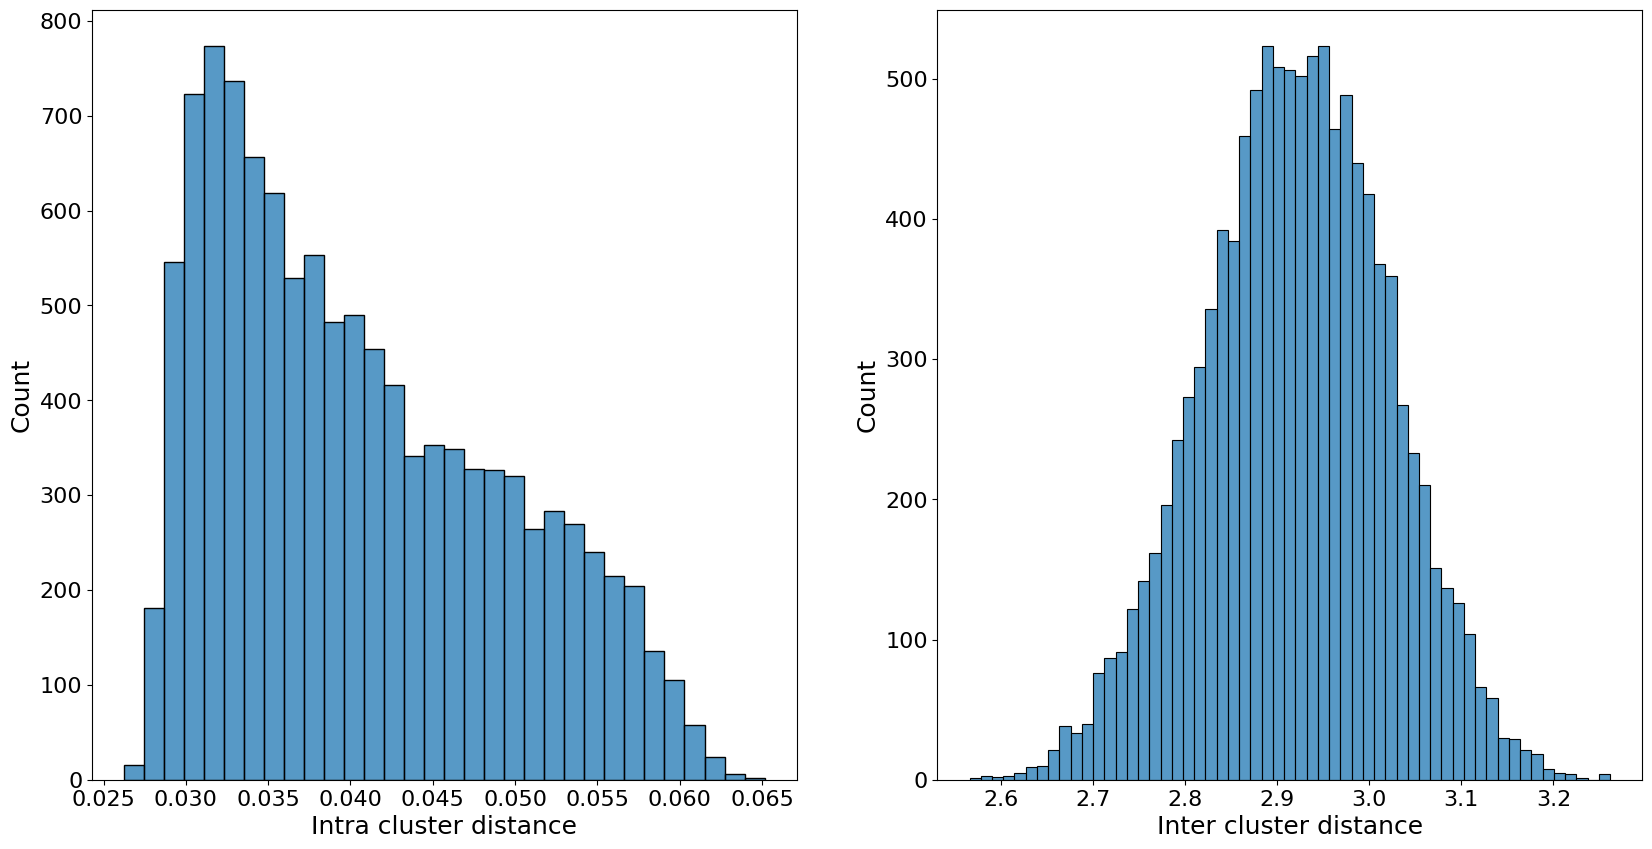

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
df_res = pd.read_csv('../results/Intra_inter_distance_101_202.csv')
sns.histplot(df_res, x='Intra', ax=ax[0])
ax[0].set_xlabel('Intra cluster distance', fontsize=18)
ax[0].set_ylabel('Count', fontsize=18)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=16)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=16)

sns.histplot(df_res, x='Inter', ax=ax[1])
ax[1].set_xlabel('Inter cluster distance', fontsize=18)
ax[1].set_ylabel('Count', fontsize=18)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=16)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=16)

plt.show()

In [ ]:
"""tmp = data[data.ClsID==1].sort_values('seq_index')
display(tmp.head())
print(tmp.shape)
with open('../Data/cluster_1.fa', 'w') as f:
    [f.write(f">g1|{a}\n{b}\n") for a,b in zip(tmp.seq_index.values.tolist(), tmp.sequence.values.tolist())]

"""

sequence  seq_index  predictions  gc_content  ClsID  \
0  ACCCATGTCTGGCGAAAGTTATACA        146           20        0.44      1   
1  TGGCAGAGATAAACTCCACCGCAGT        175           21        0.52      1   
3  TCAACCTTGGCCGTGAGATATGTAA        989           11        0.44      1   
4  CCGAAACGGTGCAGATCCAACTTAA       1321           22        0.48      1   
5  CTTAGGTCTCCAACGTAGCGATGAA       1343           24        0.48      1   

  Status   Score  
0      M  0.9032  
1      M  0.8278  
3      M  0.8422  
4      M  0.8331  
5      M  0.8160

(47766, 7)


data.sort_values('seq_index', inplace=True)
with open(os.path.join(data_path, "random_25mers_10M.fasta"), "w") as f:
    [f.write(f"{a}\n{b}\n") for a,b in zip(data.char,data.sequence)]

## Computing mean and std of prediction scores of each cluster

In [5]:
df_agg = data.groupby('ClsID').agg({
    'prediction_score': ['mean', 'std', 'count']
}).reset_index()
display(df_agg)
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
print(df_agg.columns)
df_agg.rename(columns={
    'prediction_score_count': 'Count',
    'prediction_score_mean': 'predictions_mean',
    'prediction_score_std': 'predictions_std',
    'ClsID_':'ClsID'
}, inplace=True)
df_agg.head()

ClsID prediction_score                 
                         mean       std  count
0          1        17.310482  2.774003  44695
1          2        17.687784  2.623637   4625
2          3        18.351416  2.573043  40075
3          4        18.513920  2.568151  19001
4          5        16.731278  2.840369   1816
...      ...              ...       ...    ...
79792  79793        22.000000       NaN      1
79793  79794        17.000000       NaN      1
79794  79795        19.000000       NaN      1
79795  79796        21.000000       NaN      1
79796  79797        16.000000       NaN      1

[79797 rows x 4 columns]

Index(['ClsID_', 'prediction_score_mean', 'prediction_score_std',
       'prediction_score_count'],
      dtype='object')


ClsID  predictions_mean  predictions_std  Count
0      1         17.310482         2.774003  44695
1      2         17.687784         2.623637   4625
2      3         18.351416         2.573043  40075
3      4         18.513920         2.568151  19001
4      5         16.731278         2.840369   1816

In [6]:
df_agg.Count.min(), df_agg.predictions_mean.max()
df_agg.to_csv(os.path.join(data_path, 'cluster_mean_std_pred_score_count_IDS_80_noc.csv'), index=False)

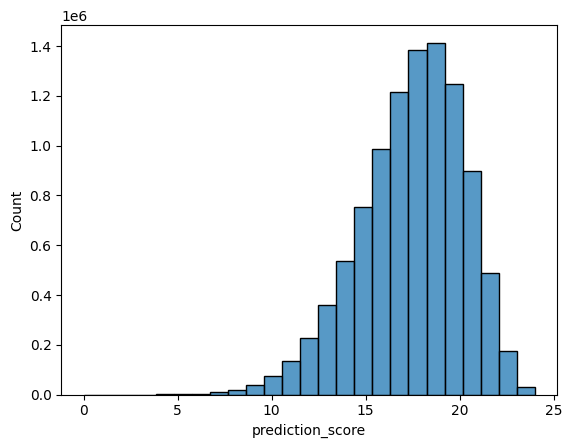

In [8]:
sns.histplot(data, x='prediction_score', bins=25)
plt.show()

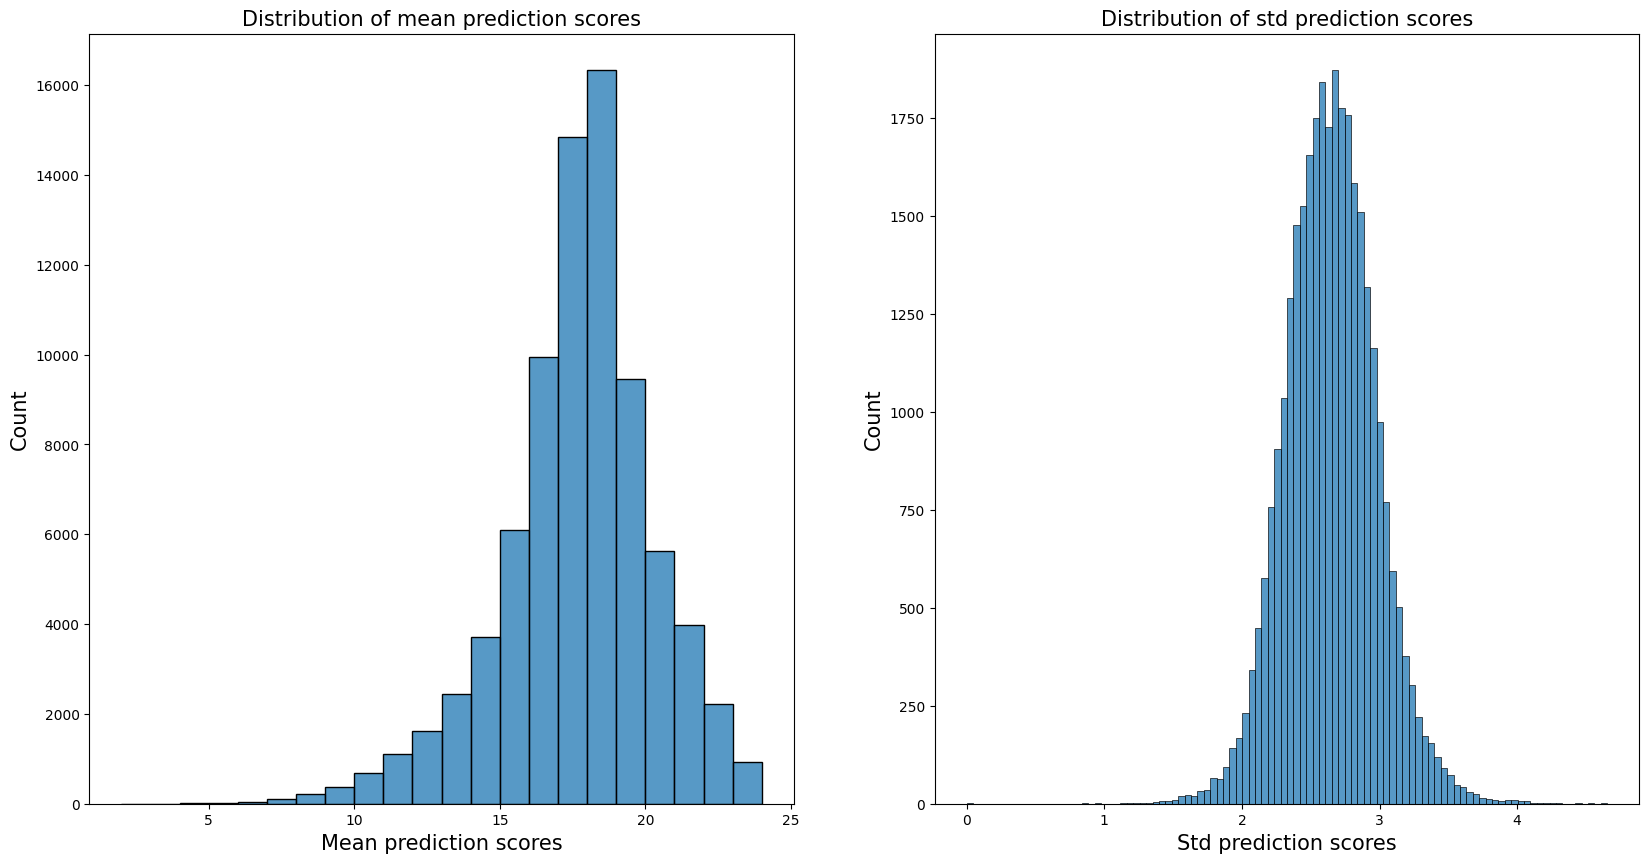

In [11]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)
sns.histplot(df_agg, x='predictions_mean', bins=22, ax=ax[0])
ax[0].set_title('Distribution of mean prediction scores', fontsize=15)
ax[0].set_xlabel('Mean prediction scores', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
sns.histplot(df_agg, x='predictions_std', bins=100, ax=ax[1])
ax[1].set_title('Distribution of std prediction scores', fontsize=15)
ax[1].set_xlabel('Std prediction scores', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
plt.show()

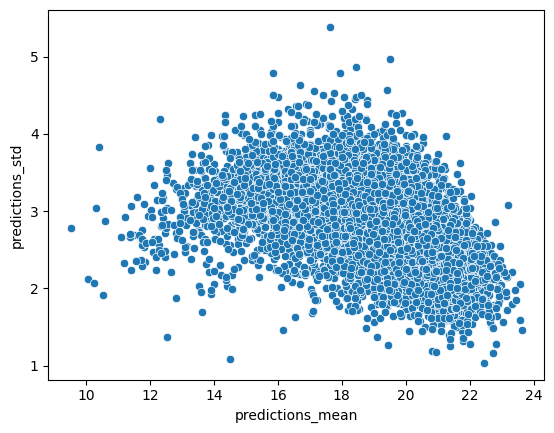

In [7]:
# Group based on low prediction and high prediction score
sns.scatterplot(data=df_agg, x='predictions_mean', y='predictions_std')
plt.show()

In [24]:
tmp = df_agg.sort_values(['predictions_mean', 'Count'], ascending=[True, False])
tmp[tmp.Count>=100].predictions_mean.min(), tmp[tmp.Count>=100].predictions_mean.max()

(np.float64(9.642276422764228), np.float64(20.651006711409394))

2.0 12.0 21.0 24.0
4006 7131 11137 62010816


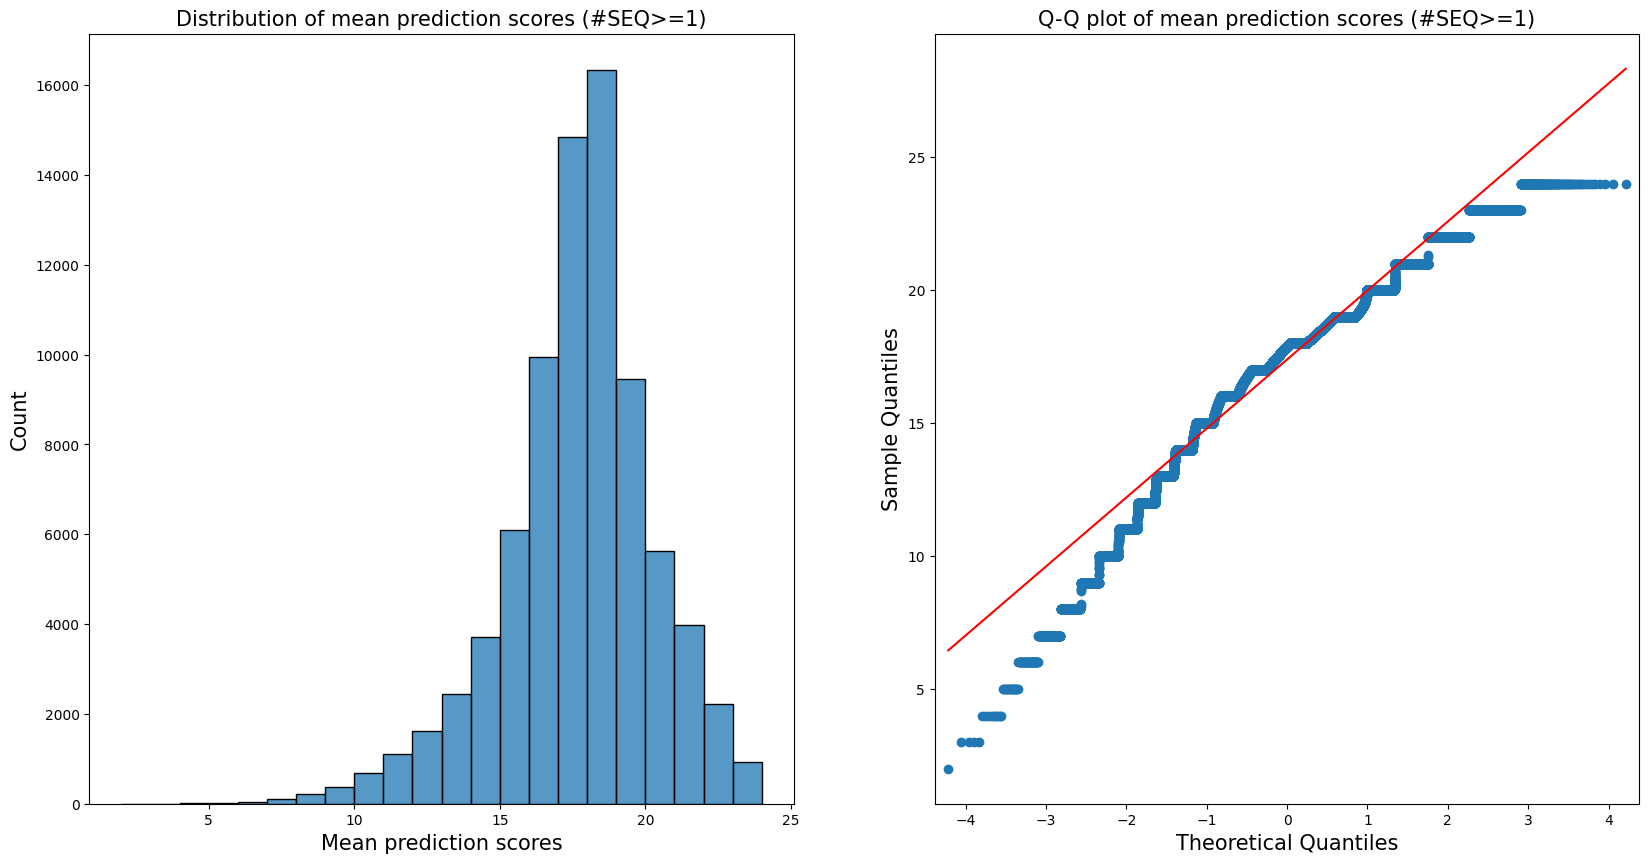

In [13]:
n = 1
df_agg_limit = df_agg[df_agg.Count>=n]
qval = np.quantile(df_agg_limit.predictions_mean.values, [0.05, 0.95])
print(df_agg_limit.predictions_mean.min(), qval[0], qval[1], df_agg_limit.predictions_mean.max())
a = df_agg_limit.ClsID[df_agg.predictions_mean<=qval[0]].nunique()
b = df_agg_limit.ClsID[df_agg.predictions_mean>=qval[1]].nunique()
print(a, b, a+b, (a+b)*(a+b-1)//2)

fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)
sns.histplot(df_agg_limit, x='predictions_mean', ax=ax[0], bins=22)
ax[0].set_title(f'Distribution of mean prediction scores (#SEQ>={n})', fontsize=15)
ax[0].set_xlabel('Mean prediction scores', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)

qqplot(df_agg_limit.predictions_mean.values, line ='s', ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles', fontsize=15)
ax[1].set_ylabel('Sample Quantiles', fontsize=15)
ax[1].set_title(f'Q-Q plot of mean prediction scores (#SEQ>={n})', fontsize=15)
plt.show()


In [22]:
l = qval[0]
h = qval[1]
print(f"Low cut-off=[{df_agg_limit.predictions_mean.min()} - {l}]\nHigh cut-off=[{h} - {df_agg_limit.predictions_mean.max()}]")
#print(df_agg_limit.ClsID.nunique())
a = df_agg_limit.ClsID[df_agg_limit.predictions_mean<=l].unique()
b = df_agg_limit.ClsID[df_agg_limit.predictions_mean>=h].unique()
c = df_agg_limit.ClsID[(df_agg_limit.predictions_mean>l)&(df_agg_limit.predictions_mean<h)].unique()
sl, sm, sh = set(a), set(c), set(b)
del [a,b,c]

print(f"{len(sl)} low scoring clusters have {data.sequence[data.ClsID.isin(list(sl))].nunique()} sequences")
print(f"{len(sm)} medium scoring clusters have {data.sequence[data.ClsID.isin(list(sm))].nunique()} sequences")
print(f"{len(sh)} high scoring clusters have {data.sequence[data.ClsID.isin(list(sh))].nunique()} sequences")

Low cut-off=[9.521739130434783 - 16.755124936257012]
High cut-off=[21.455825573472634 - 23.63157894736842]
1536 low scoring clusters have 129745 sequences
27633 medium scoring clusters have 6951362 sequences
1536 high scoring clusters have 179738 sequences


In [ ]:
def create_motif_fasta(cid_set, folder='motif', type='L'):
    if type in ['L', 'H']:
        val = []
        for cid in cid_set:
            tmp = data[data.ClsID==cid].sort_values('seq_index')
            
            for a,b in zip(tmp.seq_index.values.tolist(), tmp.sequence.values.tolist()):
                val.append(f">g1|{type}{cid}|{a}")
                val.append(b)

        with open(os.path.join(data_path, folder, f'cluster_{type}.fa'), 'w') as f:
            f.write('\n'.join(val))
    else:
        t = 0
        val = []
        cnt = 0
        for cid in cid_set:
            tmp = data[data.ClsID==cid].sort_values('seq_index')
            if cnt+tmp.sequence.nunique()>1000000:
                t+=1
                with open(os.path.join(data_path, folder, f'cluster_M_{t}.fa'), 'w') as f:
                    f.write('\n'.join(val))
                val = []
                cnt = 0

            for a,b in zip(tmp.seq_index.values.tolist(), tmp.sequence.values.tolist()):
                val.append(f">g1|M{cid}|{a}")
                val.append(b)

            cnt += tmp.sequence.nunique()

        if len(val)>0:
            t+=1
            with open(os.path.join(data_path, folder, f'cluster_M_{t}.fa'), 'w') as f:
                f.write('\n'.join(val))


create_motif_fasta(sl, type='L', folder='motif/more10')
create_motif_fasta(sh, type='H', folder='motif/more10')
create_motif_fasta(sm, type='M', folder='motif/more10')


[1-31832] 30704 23071
23186 low scoring clusters have 6788936 sequences
30704 medium scoring clusters have 7260830 sequences
23071 high scoring clusters have 6841101 sequences


In [18]:
x = range(1, 1001)
y = np.array_split(x, np.floor(len(x)/10))
sum([len(a) for a in y])

1000

In [17]:
def create_motif_fasta_for_all_sequences(rng, folder='motif', type='L'):
    tmp = data[np.logical_and(data.prediction_score>=rng[0], data.prediction_score<=rng[1])].sort_values('seq_index')  
    print(f"[{rng[0]}-{rng[1]}] has sequences = {tmp.sequence.nunique()}")

    if os.path.exists(os.path.join(data_path, folder))==False:
        os.makedirs(os.path.join(data_path, folder), exist_ok=True) 
        
    if type in ['L', 'H']:
        val = []
        for cid,a,b in zip(tmp.ClsID.values.tolist(), tmp.seq_index.values.tolist(), tmp.sequence.values.tolist()):
            val.append(f">g1|{type}{cid}|{a}")
            val.append(b)

        with open(os.path.join(data_path, folder, f'cluster_{type}.fa'), 'w') as f:
            f.write('\n'.join(val))
    else:
        for t in range(2):
            # Shuffle the dataframe rows
            tmp = tmp.sample(frac=1).reset_index(drop=True)

            # Random sample 1 million sequences
            s = tmp.sample(1000000).seq_index.values

            #seq_split = np.array_split(tmp.seq_index.values, np.floor(len(tmp.seq_index.values)/1000000))
            #for t, s in enumerate(seq_split):
            print(len(s))
            val = []
            tmp1 = tmp[tmp.seq_index.isin(s)]
            for cid,a,b in zip(tmp1.ClsID.values.tolist(), tmp1.seq_index.values.tolist(), tmp1.sequence.values.tolist()):
                val.append(f">g1|M{cid}|{a}")
                val.append(b)

            with open(os.path.join(data_path, folder, f'cluster_M_{t+1}.fa'), 'w') as f:
                f.write('\n'.join(val))


#print(f"[2-13] low scoring clusters have {data.sequence[data.predictions<=13].nunique()} sequences")
#print(f"[14-24] medium scoring clusters have {data.sequence[np.logical_and(data.predictions>13, data.predictions<25)].nunique()} sequences")
#print(f"[25-27] high scoring clusters have {data.sequence[data.predictions>=25].nunique()} sequences")

#[2-13] low scoring clusters have 368513 sequences
#[14-24] medium scoring clusters have 9311762 sequences
#[25-27] high scoring clusters have 319725 sequences

l,h=10,23
print(f"[0-{l}] low scoring clusters have {data.sequence[data.prediction_score<=l].nunique()} sequences")
print(f"[{l+1}-{h-1}] medium scoring clusters have {data.sequence[np.logical_and(data.prediction_score>l, data.prediction_score<h)].nunique()} sequences")
print(f"[{h}-24] high scoring clusters have {data.sequence[data.prediction_score>=h].nunique()} sequences")


create_motif_fasta_for_all_sequences((0,l), type='L', folder='motif/all_rs_noc/v2')
create_motif_fasta_for_all_sequences((h,24), type='H', folder='motif/all_rs_noc/v2')
create_motif_fasta_for_all_sequences((l+1,h-1), type='M', folder='motif/all_rs_noc/v2')


[0-10] low scoring clusters have 147770 sequences
[11-22] medium scoring clusters have 9647046 sequences
[23-24] high scoring clusters have 205184 sequences
[0-10] has sequences = 147770
[23-24] has sequences = 205184
[11-22] has sequences = 9647046
1000000
1000000


In [29]:
72335+7089950+2837715

10000000

In [50]:
motif_loc = os.path.join(data_path, 'motif', 'all_random_shuffle')

for t in ['H', 'L', 'M_1', 'M_2', 'M_3', 'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'M_9', 'M_10']:
    fa_data = None
    with open(os.path.join(motif_loc, f'cluster_{t}.fa'), 'r') as f:
        fa_data = f.readlines()

    seq = [fa_data[i].strip() for i in range(1,len(fa_data), 2)]
    pm = data.prediction_score[data.sequence.isin(seq)].values.tolist()
    print(t, min(pm), max(pm))    

H 22 24
L 0 13
M_1 11 24
M_2 11 24
M_3 11 24
M_4 11 24
M_5 11 24
M_6 11 24
M_7 11 24
M_8 11 24
M_9 11 24
M_10 11 24


0 13


In [46]:
639450//2

319725

In [24]:
sum([1128158,
1128157,
1128157,
1128157,
1128157,
1128157])

6768943

In [7]:
data.predictions.min(), data.predictions.max()

(np.int64(2), np.int64(27))

In [12]:
files = os.listdir(os.path.join(data_path, 'motif/'))
print(len(files))
print([f[:-3] for f in files[:10]])

21
['cluster_M_9', 'cluster_M_18', '.DS_St', 'cluster_M_8', 'cluster_M_17', 'cluster_M_3', 'cluster_L', 'cluster_M_13', 'cluster_M_7', 'cluster_H']


In [13]:
sl = df_agg.ClsID[df_agg.predictions_mean<13.5].unique()
sh = df_agg.ClsID[df_agg.predictions_mean>22.5].unique()
print(set(sl).intersection(set(sh)))
print(sl)
print(sh)
print(len(set(sl).union(set(sh))))

set()
[  394  2599  3406  3476  3548  3570  3641  3935  5040  5060  5145  6295
  6741  6919  8898  9833 10132 10819 10842 10883 10926 11259 11376 11425
 11459 11496 12342 12384 12874 13416 14122 14209 14478 14767 15191 15320
 15993 16002 16790 17171 17583 18404 18496 18656 18893 19165 19836 19978
 20661 20759 20879 21011 21056 21161 21315 21383 21390 21602 21964 21982
 22332 22398 22591 22732 23162 23412 23488 23493 23743 23758 23872 23894
 24093 24140 24176 24710 24848 25017 25080 25087 25156 25521 25729 25790
 26052 26112 26436 26500 26803 26821 27076 27150 27297 27519 27524 27651
 27694 27837 27859 27985 27988 28307 28629 28664 28670 28817 29028 29054
 30028 30057 30114 30301 30318 30443 30661 30766 30889 31076 31335 31565
 31579]
[ 4865  7442  7948 10206 10208 10266 12603 12708 12782 12837 12889 13586
 13770 13954 14319 14458 14876 15025 15375 16149 16236 16399 16890 17783
 18408 18597 19086 19205 19684 19828 20121 20202 20493 20691 20797 20859
 21732 22335 22829 23624 23668 23868 

In [14]:
cluster_labels = sorted(df_agg.ClsID[np.logical_or(df_agg.predictions_mean<13.5, df_agg.predictions_mean>22.5)].unique())
cluster_labels[:5]

[np.int64(394), np.int64(2599), np.int64(3406), np.int64(3476), np.int64(3548)]

In [15]:
cluster_labels = sorted(df_agg.ClsID[np.logical_or(df_agg.predictions_mean<13.5, df_agg.predictions_mean>22.5)].unique())
p = data.predictions[data.ClsID==cluster_labels[1]].values
p

array([12, 12, 12,  8, 11, 12, 15, 14, 17, 11, 12, 11, 17, 15, 15, 15, 14,
       10, 15, 17,  6,  9, 11, 17, 17, 12, 16, 17,  9, 14, 11, 14, 16, 16,
       18, 11, 13, 17, 12, 14, 12,  9, 13, 11, 14, 11, 11, 16, 21,  5, 15,
       13, 13, 12, 11, 11, 12, 13, 16, 14, 12, 17, 16, 13, 12, 20, 18, 15,
       12, 13, 11, 20, 15, 14, 14, 14, 14, 12, 10, 15, 13, 14, 11,  8, 18,
       12,  9, 12, 16])

In [16]:
sl = set(df_agg.ClsID[df_agg.predictions_mean<13.5].unique())
sh = set(df_agg.ClsID[df_agg.predictions_mean>22.5].unique())
cluster_labels = sorted(df_agg.ClsID[np.logical_or(df_agg.predictions_mean<13.5, df_agg.predictions_mean>22.5)].unique())

significant_inter_clusters = {
    'ttest_ind':[],
    'mannwhitneyu':[],
    'wilcoxon':[],
    'fligner':[]
}
significant_intra_clusters = {
    'ttest_ind':[],
    'mannwhitneyu':[],
    'wilcoxon':[],
    'fligner':[]
}

def process_time(start: float, end: float, s=""):
    elapsed = end - start
    hours, remainder = divmod(elapsed, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Time taken{' for ['+s+']' if len(s)>0 else ''}: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

def get_members(i,j):
    score1 = data.predictions[data.ClsID==cluster_labels[i]].values
    score2 = data.predictions[data.ClsID==cluster_labels[j]].values
    return score1, score2

def get_cluster_id_in_order(c1, c2):
    return (c1, c2) if c1<=c2 else (c2, c1)

def hypotheis_test(score1, score2, c1, c2, fname):
    # Perform the t-test
    _, p_val = fname(score1, score2)

    # Adjust for multiple hypothesis testing
    p_val_adj = multipletests(p_val, method='fdr_bh')[1]

    if p_val_adj < 0.05:
        if (c1 in sl and c2 in sh) or (c1 in sh and c2 in sl):
            significant_inter_clusters[fname.__name__].append(get_cluster_id_in_order(c1, c2))
        else:
            significant_intra_clusters[fname.__name__].append(get_cluster_id_in_order(c1, c2))

st = timeit.default_timer()
for i in range(len(cluster_labels)):
    for j in range(i+1, len(cluster_labels)):
        score1 = data.predictions[data.ClsID==cluster_labels[i]].values
        score2 = data.predictions[data.ClsID==cluster_labels[j]].values
        min_sample = min(len(score1), len(score2))
        #try:
            
        # Perform the t-test
        hypotheis_test(score1, score2, cluster_labels[i],cluster_labels[j],ttest_ind)

        # Perform the Mann-Whitney U test
        hypotheis_test(score1, score2, cluster_labels[i],cluster_labels[j],mannwhitneyu)

        # Perform the Wilcoxon Signed-Rank Test
        hypotheis_test(np.random.choice(score1, size=min_sample), np.random.choice(score2, size=min_sample), cluster_labels[i],cluster_labels[j],wilcoxon)

        # Perform the Fligner-Killeen Test
        hypotheis_test(score1, score2, cluster_labels[i],cluster_labels[j],fligner)

        #except Exception as e:
        #    print(f"Error for ({cluster_labels[i]}, {cluster_labels[j]}). Error details: {e}")

process_time(st, timeit.default_timer())

print('Inter cluster:')
for k in significant_inter_clusters:
    print(f'{k}={len(significant_inter_clusters[k])}')

print('Intra cluster:')
for k in significant_intra_clusters:
    print(f'{k}={len(significant_intra_clusters[k])}')

KeyboardInterrupt: 

In [ ]:
setV = set(significant_inter_clusters['ttest_ind'])
for k in significant_inter_clusters:
    if k in ['ttest_ind', 'wilcoxon']: continue
    setV = setV.intersection(set(significant_inter_clusters[k]))

len(setV)

4491

In [ ]:
selLow = set()
selHigh = set()

highband = set([1955,5464,33530,10280,26917,27891,12170,14426,37679])
lowband = set([5359,7846,5178,25826,8138,10555,12089,7467,26224,19893,17274,13612,18618,29962,26115])

res = {
    'high_avg_score':[],
    'low_avg_score':[]
}
for h in highband:
    for l in lowband:
        if h>l: h,l = l,h
        if (h,l) in setV: 
            if h in highband:
                res['high_avg_score'].append(h)
                res['low_avg_score'].append(l)
            else:
                res['high_avg_score'].append(l)
                res['low_avg_score'].append(h)

len(res)

2

In [ ]:
td = pd.DataFrame(res)
td.to_csv(os.path.join(data_path, 'significant_clusters_high_low_avgscore.csv'), index=False)


In [ ]:
hv = set(td.high_avg_score.values)
lv = set(td.low_avg_score.values)
sig_cls = list(hv.union(lv))
for cid in sig_cls:
    tmp = data[data.ClsID==cid].sort_values('seq_index')
    print(f"cluster {cid} data size={tmp.shape}")
    with open(os.path.join(data_path, f'motif/cluster_{cid}.fa'), 'w') as f:
        [f.write(f">g1|{a}\n{b}\n") for a,b in zip(tmp.seq_index.values.tolist(), tmp.sequence.values.tolist())]

cluster 26115 data size=(100, 7)
cluster 5178 data size=(208, 7)
cluster 12170 data size=(156, 7)
cluster 8138 data size=(178, 7)
cluster 29962 data size=(101, 7)
cluster 5464 data size=(182, 7)
cluster 14426 data size=(150, 7)
cluster 25826 data size=(179, 7)
cluster 1955 data size=(260, 7)
cluster 26917 data size=(163, 7)
cluster 7846 data size=(224, 7)
cluster 10280 data size=(164, 7)
cluster 18618 data size=(102, 7)
cluster 7467 data size=(130, 7)
cluster 37679 data size=(120, 7)
cluster 5359 data size=(382, 7)
cluster 26224 data size=(111, 7)
cluster 27891 data size=(158, 7)
cluster 19893 data size=(109, 7)
cluster 12089 data size=(146, 7)
cluster 33530 data size=(172, 7)
cluster 10555 data size=(159, 7)
cluster 17274 data size=(106, 7)


In [ ]:
len(sorted([int(x) for x in sig_cls]))

23

## Motif finding [STREME]

In [66]:
df_sig = pd.read_csv(os.path.join(data_path, 'significant_clusters_high_low_avgscore.csv'))
df_sig.head()

high_avg_score  low_avg_score
0            1955          25826
1            1955          26115
2            1955           7846
3            1955          18618
4            1955           8138

In [85]:
motif_path = os.path.join(data_path, 'motif/results')
motif_seq = {
    'clsID':[],
    'class':[],
    'Motif_1':[],
    'Motif_2':[],
    'Motif_3':[],
    'Motif_4':[],
    'Motif_5':[],
}
for cid in set(df_sig.high_avg_score.values):
    motif_seq['clsID'].append(cid)
    motif_seq['class'].append('high')
    tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{cid}/sequences.tsv"), sep='\t')
    turn=1
    for seq in tmp.motif_ID.unique():
        if seq=='#': continue
        motif_seq[f'Motif_{turn}'].append(seq[2:])
        turn+=1
    #display(tmp.head())
    #break

for cid in set(df_sig.low_avg_score.values):
    motif_seq['clsID'].append(cid)
    motif_seq['class'].append('low')
    tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{cid}/sequences.tsv"), sep='\t')
    turn=1
    for seq in tmp.motif_ID.unique():
        if seq=='#': continue
        motif_seq[f'Motif_{turn}'].append(seq[2:])
        turn+=1
    #display(tmp.head())
    #break

tmp = pd.DataFrame(motif_seq)
tmp.to_csv(os.path.join(data_path, 'motif_high_low.csv'), index=False)
tmp

clsID class        Motif_1        Motif_2         Motif_3  \
0    1955  high     TAGAGTTCRG      CAGCGAGCS       ATACTCGAA   
1   33530  high     GCTCGCTAAC         ACGCCM           SKKCC   
2   26917  high   AAGCGMAGGCGT      AACTTGCGC      ACGCTGCCTD   
3   10280  high  CGYYCGAMCKTTY   AGSGACGTTCSG  GKTTCGACNGAAMS   
4   12170  high      CGTCCGRCG        GCGARAT       GCCCGTCGA   
5   37679  high      AAGCGGCGT  ACGTTACTTGCCK    CGGKMAARHRCA   
6   27891  high     CGCGCGAHGA    GTCATCGMAVA         GACGTCA   
7    5464  high       CGCTTKGC         TCCGAG       AGAAGCCGC   
8   14426  high         ACGAGA       CGGCGACG       ACGTTTTGC   
9   25826   low      CGCCCCCCC  CTGCCCGCCGGGS         AGSTCVG   
10  26115   low       CCGGGACA      CCGGGGGCS         AGCGCCG   
11   5178   low   GCACCTGGGCCC       CGGCCTGC  CAGGCCTGGGCCCC   
12   7846   low      GGGCGGGCA     GGCCVBGGCC       CAGGCGCAC   
13   8138   low    GGRGCCGKCAS       AGSACGSG        ACCCGGCG   
14   7467   low    GGCCATCGGCC      GGGCCAGGC        AGTCCRGG   
15  29962   low        CCGCCTC   CGGGGAGCCCCC       AGGGWCCCT   
16   5359   low    ACCGCGGGSCC       AGGCTGGG       CGGGAGCCG   
17  26224   low        GCCCGGA      CCGACCCCA   AGCCCCCCGCCAG   
18  19893   low         AGCTGG      AAGGCCCGG   CCAGAGGGCASCC   
19  12089   low        CMCCGCC       AGTGCCCC       CSGTCCACC   
20  18618   low        ACCCAGA       GCKGCMGC         AATGGGC   
21  10555   low   AGGGGTCTSCSC        CTGAGCA          CGGGCC   
22  17274   low      CSCGGSCCS       CACCGGCG     CGCGGCSCMKG   

             Motif_4         Motif_5  
0           AAGTGCGC       ATCGCAGAG  
1         AAACGCGTTT     GTWGCAMGCGC  
2         CGCAAAAGTT      CGCGCTTTGA  
3        CGCTTCTTCGW    GAAACYTTCGTM  
4          GGATCGWCR           AGTAG  
5         GCGCTGACCC       MGGTCGTAG  
6           GCTTCGCG      WATCGCGATW  
7           CGGCGCGA        CAAGGAAG  
8      ACGACGCWCGAAS           TCCRG  
9   STGGTCAGKGSCGSCG   CCSCGAGGCCCAC  
10       CGGCGGSGSCC      AGCCGCCCGG  
11         GCTGGCCAC         CTCCCGC  
12          CTCCGCCA       MGGMNKCCK  
13         CCCCCTSGM        ACGTCGGG  
14         CCCCAGGGS         CATCCCG  
15        CGGCCCCSGS         CCGTSCG  
16       ASGSRGGSCCG        CCCGCACG  
17          RCCTCCCC      CGAGCGGCCC  
18           TCAGGGG          SAGCGA  
19        ACGGGGTGSC  CCCAGMCCCCGTGS  
20         CCSCATSCC       CCGGCCTAG  
21         GAGGCCAKG        ASCCCAGA  
22       CCATCGSGCGG      CCATGGABGC

In [82]:
tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{33530}/sequences.tsv"), sep='\t')
tmp.motif_ID.unique()

array(['1-GCTCGCTAAC', '#', '2-ACGCCM', '3-SKKCC', '4-AAACGCGTTT',
       '5-GTWGCAMGCGC'], dtype=object)

## Motif finding [MEME]

In [86]:
df_sig = pd.read_csv(os.path.join(data_path, 'significant_clusters_high_low_avgscore.csv'))
df_sig.head()

high_avg_score  low_avg_score
0            1955          25826
1            1955          26115
2            1955           7846
3            1955          18618
4            1955           8138

In [110]:
import subprocess
def getMotif(motif_path, cid, type, res, turn=5):
    try:
        # Execute the sbatch command
        result = subprocess.run(f"grep -e 'E-value =' -e 'Multilevel' {os.path.join(motif_path, f"cluster_{cid}/meme.txt")}", capture_output=True, text=True, check=True, shell=True)
        rv = result.stdout.strip().split() # Assuming sbatch returns job ID on last line
        ei, mi=-1,-1
        print(f'Cluster={cid}')
        for _ in range(turn):
            res['ClsID'].append(cid)
            res['type'].append(type)
            ei = rv.index('E-value', ei+1)
            ev = float(rv[ei+2])
            res['eval'].append(ev)
            mi = rv.index('Multilevel', mi+1)
            mv = rv[mi+1]
            res['motif'].append(mv)
            print(f"Motif {mv} has E-value={ev}")
    except subprocess.CalledProcessError as e:
        print(f"Error submitting job: {e.stderr}")

In [111]:
motif_path = os.path.join(data_path, 'motif/MEME')
res_dict = {
    'ClsID':[],
    'type':[],
    'motif':[],
    'eval':[]
}
for cid in set(df_sig.high_avg_score.values):
    getMotif(motif_path=motif_path, cid=cid, type='high', res=res_dict)

for cid in set(df_sig.low_avg_score.values):
    getMotif(motif_path=motif_path, cid=cid, type='low', res=res_dict)

res_dict

Cluster=1955
Motif AGGTCATCGCG has E-value=3.1e-84
Motif CAAGATTA has E-value=330000.0
Motif AACGAGTAGTT has E-value=600000.0
Motif AAGTCATT has E-value=340000.0
Motif TCATTA has E-value=680000.0
Cluster=33530
Motif GCGCTAAA has E-value=6.1e-50
Motif AAGAAGTA has E-value=69000.0
Motif AGCGCACGCC has E-value=130000.0
Motif GCGCAAGTT has E-value=84000.0
Motif TAGTTT has E-value=150000.0
Cluster=26917
Motif AAAGCG has E-value=3.9e-53
Motif AGCGCG has E-value=5200.0
Motif TTCGCG has E-value=4100.0
Motif TAAGTTCA has E-value=24000.0
Motif CAGCGTTG has E-value=85000.0
Cluster=10280
Motif CGAACC has E-value=2.2e-79
Motif ACGTCG has E-value=2800.0
Motif CACGAAA has E-value=7400.0
Motif AAACGA has E-value=54000.0
Motif AAGACAAA has E-value=140000.0
Cluster=12170
Motif TATCGACG has E-value=8.6e-80
Motif ATAACG has E-value=10.0
Motif TCGCGTACGAG has E-value=8600.0
Motif AAAGTAT has E-value=160000.0
Motif ATAAAA has E-value=170000.0
Cluster=37679
Motif AAGGGGCGTAA has E-value=5.2e-42
Motif TAAAGCA

{'ClsID': [np.int64(1955),
  np.int64(1955),
  np.int64(1955),
  np.int64(1955),
  np.int64(1955),
  np.int64(33530),
  np.int64(33530),
  np.int64(33530),
  np.int64(33530),
  np.int64(33530),
  np.int64(26917),
  np.int64(26917),
  np.int64(26917),
  np.int64(26917),
  np.int64(26917),
  np.int64(10280),
  np.int64(10280),
  np.int64(10280),
  np.int64(10280),
  np.int64(10280),
  np.int64(12170),
  np.int64(12170),
  np.int64(12170),
  np.int64(12170),
  np.int64(12170),
  np.int64(37679),
  np.int64(37679),
  np.int64(37679),
  np.int64(37679),
  np.int64(37679),
  np.int64(27891),
  np.int64(27891),
  np.int64(27891),
  np.int64(27891),
  np.int64(27891),
  np.int64(5464),
  np.int64(5464),
  np.int64(5464),
  np.int64(5464),
  np.int64(5464),
  np.int64(14426),
  np.int64(14426),
  np.int64(14426),
  np.int64(14426),
  np.int64(14426),
  np.int64(25826),
  np.int64(25826),
  np.int64(25826),
  np.int64(25826),
  np.int64(25826),
  np.int64(26115),
  np.int64(26115),
  np.int64(26

In [137]:
tmp = pd.DataFrame(res_dict)
def min_eval_motif(x):
    #display(x)
    t = x.loc[x['eval']==min(x['eval']), ['motif', 'eval']]
    return t

tmp = tmp.groupby(['ClsID', 'type']).apply(min_eval_motif).reset_index()
tmp.sort_values('type', inplace=True)
#tmp = tmp[tmp['eval']<1]
print(tmp.shape)
tmp.to_csv(os.path.join(data_path, 'motif_high_low_MEME.csv'), index=False)
tmp

(23, 5)


/var/folders/4_/sddj8d8n43jfjlnp90400yrh0047ft/T/ipykernel_70734/621196886.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby(['ClsID', 'type']).apply(min_eval_motif).reset_index()


ClsID  type  level_2                   motif          eval
0    1955  high        0             AGGTCATCGCG  3.100000e-84
19  27891  high       30                CATCGCGC  1.600000e-87
18  26917  high       10                  AAAGCG  3.900000e-53
21  33530  high        5                GCGCTAAA  6.100000e-50
10  12170  high       20                TATCGACG  8.600000e-80
7   10280  high       15                  CGAACC  2.200000e-79
11  14426  high       40                  TCGAAC  1.000000e-81
3    5464  high       35             GAAGCGCCAAA  5.500000e-65
22  37679  high       25             AAGGGGCGTAA  5.200000e-42
5    7846   low       60                  ATGCCC  1.400000e-42
8   10555   low      105                    CCAG  1.400000e-25
9   12089   low       95                 TGCCCCC  1.000000e-17
4    7467   low       70                 CTGGCCC  1.300000e-27
12  17274   low      110                    GCAT  1.700000e-37
13  18618   low      100             CGGGCCCATGG  2.900000e-52
14  19893   low       90             GGGGGGGCTCG  1.400000e-25
15  25826   low       45         GGGGGGCAGGGGCCG  3.500000e-01
16  26115   low       50                    ATCC  3.100000e-29
17  26224   low       85  GGGCGGGGGGGGGGCGGGGGGG  2.900000e-21
2    5359   low       80  ACCCAGCCCGCCGCCCGGCTGG  2.600000e+02
1    5178   low       55                  CAGGGG  1.200000e-29
20  29962   low       75   ACGGGCCCCCCCCGGCGCGAG  3.200000e-01
6    8138   low       65                  CCCCTG  1.800000e+01

In [140]:
tmp = pd.read_csv(os.path.join(data_path, 'motif_high_low_MEME.csv'))
high_motif = tmp.motif[tmp.type=='high'].values.tolist()
low_motif = tmp.motif[tmp.type=='low'].values.tolist()
print(high_motif)
print(low_motif)

['AGGTCATCGCG', 'CATCGCGC', 'AAAGCG', 'GCGCTAAA', 'TATCGACG', 'CGAACC', 'TCGAAC', 'GAAGCGCCAAA', 'AAGGGGCGTAA']
['ATGCCC', 'CCAG', 'TGCCCCC', 'CTGGCCC', 'GCAT', 'CGGGCCCATGG', 'GGGGGGGCTCG', 'GGGGGGCAGGGGCCG', 'ATCC', 'GGGCGGGGGGGGGGCGGGGGGG', 'ACCCAGCCCGCCGCCCGGCTGG', 'CAGGGG', 'ACGGGCCCCCCCCGGCGCGAG', 'CCCCTG']


In [142]:
from Bio import Align
aligner = Align.PairwiseAligner()
aligner.mode='global'

In [153]:
print(aligner.match_score)
print(aligner.mismatch_score)
print(aligner.gap_score)
print(aligner.open_gap_score)

1.0
0.0
0.0
0.0


In [157]:
max_score=0
max_score_pair = []
for s1 in ['AGGTCATCGCG', 'CATCGCGC', 'AAAGCG', 'GCGCTAAA', 'TATCGACG', 'CGAACC', 'TCGAAC', 'GAAGCGCCAAA', 'AAGGGGCGTAA']:
    for s2 in ['ATGCCC', 'CCAG', 'TGCCCCC', 'CTGGCCC', 'GCAT', 'CGGGCCCATGG', 'GGGGGGGCTCG', 'GGGGGGCAGGGGCCG', 'ATCC', 'GGGCGGGGGGGGGGCGGGGGGG', 'ACCCAGCCCGCCGCCCGGCTGG', 'CAGGGG', 'ACGGGCCCCCCCCGGCGCGAG', 'CCCCTG']:
        res = aligner.align(s1, s2)
        max_score = max(max_score, res.score)
        #print(res.score)
        #print(res[0])
        #print()

for s1 in ['AGGTCATCGCG', 'CATCGCGC', 'AAAGCG', 'GCGCTAAA', 'TATCGACG', 'CGAACC', 'TCGAAC', 'GAAGCGCCAAA', 'AAGGGGCGTAA']:
    for s2 in ['ATGCCC', 'CCAG', 'TGCCCCC', 'CTGGCCC', 'GCAT', 'CGGGCCCATGG', 'GGGGGGGCTCG', 'GGGGGGCAGGGGCCG', 'ATCC', 'GGGCGGGGGGGGGGCGGGGGGG', 'ACCCAGCCCGCCGCCCGGCTGG', 'CAGGGG', 'ACGGGCCCCCCCCGGCGCGAG', 'CCCCTG']:
        res = aligner.align(s1, s2)
        if res.score==max_score:
            max_score_pair.append((s1, s2))

print(f"Maximum score=",max_score)
#print(max_score_pair)

for s1, s2 in max_score_pair:
    res = aligner.align(s1, s2)
    print(res[0])
    print()

Maximum score= 8.0
target            0 A----G---GTCATCGC--G----- 11
                  0 |----|---|-|--|||--|----- 25
query             0 ACCCAGCCCG-C--CGCCCGGCTGG 22


target            0 A-GGT-CATC------G-CG---- 11
                  0 |-||--|--|------|-||---- 24
query             0 ACGG-GC--CCCCCCCGGCGCGAG 21


target            0 A---AG---G--GGC--G--TAA-- 11
                  0 |---||---|--|-|--|--|---- 25
query             0 ACCCAGCCCGCCG-CCCGGCT--GG 22


target            0 AA-GGG--------G-CGT--AA- 11
                  0 |--|||--------|-||---|-- 24
query             0 A-CGGGCCCCCCCCGGCG-CGA-G 21




In [ ]:
f

In [135]:
motif_path = os.path.join(data_path, 'motif/STREME')
tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{1955}/sequences.tsv"), sep='\t')
tmp.head()

motif_ID motif_ALT_ID  motif_P-value      seq_ID  seq_Score seq_Class  \
0  1-TAGAGTTCRG     STREME-1            0.5  g1|1704141      14.84        tp   
1  1-TAGAGTTCRG     STREME-1            0.5   g1|313070      14.26        tp   
2  1-TAGAGTTCRG     STREME-1            0.5  g1|3617962      14.12        tp   
3  1-TAGAGTTCRG     STREME-1            0.5  g1|1524970      14.01        tp   
4  1-TAGAGTTCRG     STREME-1            0.5  g1|1908468      13.86        tp   

   is_holdout?  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [ ]:
motif_path = os.path.join(data_path, 'motif/STREME')
motif_seq = {
    'clsID':[],
    'class':[],
    'Motif_1':[],
    'Motif_2':[],
    'Motif_3':[],
    'Motif_4':[],
    'Motif_5':[],
}

for cid in set(df_sig.high_avg_score.values):

    motif_seq['clsID'].append(cid)
    motif_seq['class'].append('high')
    tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{cid}/sequences.tsv"), sep='\t')
    turn=1
    for seq in tmp.motif_ID.unique():
        if seq=='#': continue
        motif_seq[f'Motif_{turn}'].append(seq[2:])
        turn+=1
    #display(tmp.head())
    #break

for cid in set(df_sig.low_avg_score.values):
    motif_seq['clsID'].append(cid)
    motif_seq['class'].append('low')
    tmp = pd.read_csv(os.path.join(motif_path, f"cluster_{cid}/sequences.tsv"), sep='\t')
    turn=1
    for seq in tmp.motif_ID.unique():
        if seq=='#': continue
        motif_seq[f'Motif_{turn}'].append(seq[2:])
        turn+=1
    #display(tmp.head())
    #break

tmp = pd.DataFrame(motif_seq)
tmp.to_csv(os.path.join(data_path, 'motif_high_low_MEME.csv'), index=False)
tmp

In [79]:
pd.DataFrame(motif_seq)

clsID class        Motif_1        Motif_2         Motif_3        Motif_4  \
0   1955  high     TAGAGTTCRG      CAGCGAGCS       ATACTCGAA       AAGTGCGC   
1  33530  high     GCTCGCTAAC         ACGCCM           SKKCC     AAACGCGTTT   
2  26917  high   AAGCGMAGGCGT      AACTTGCGC      ACGCTGCCTD     CGCAAAAGTT   
3  10280  high  CGYYCGAMCKTTY   AGSGACGTTCSG  GKTTCGACNGAAMS    CGCTTCTTCGW   
4  12170  high      CGTCCGRCG        GCGARAT       GCCCGTCGA      GGATCGWCR   
5  37679  high      AAGCGGCGT  ACGTTACTTGCCK    CGGKMAARHRCA     GCGCTGACCC   
6  27891  high     CGCGCGAHGA    GTCATCGMAVA         GACGTCA       GCTTCGCG   
7   5464  high       CGCTTKGC         TCCGAG       AGAAGCCGC       CGGCGCGA   
8  14426  high         ACGAGA       CGGCGACG       ACGTTTTGC  ACGACGCWCGAAS   

        Motif_5  
0     ATCGCAGAG  
1   GTWGCAMGCGC  
2    CGCGCTTTGA  
3  GAAACYTTCGTM  
4         AGTAG  
5     MGGTCGTAG  
6    WATCGCGATW  
7      CAAGGAAG  
8         TCCRG

In [ ]:
score1 = data.predictions[data.ClsID==cluster_labels[i]].values
            score2 = data.predictions[data.ClsID==cluster_labels[j]].values

            
            _, p_val_tt = ttest_ind(score1, score2)

            # Adjust for multiple hypothesis testing
            p_val_adj = multipletests(p_val_tt, method='fdr_bh')[1]
            #print(cluster_labels[i], cluster_labels[j], len(score1), len(score2), p_val_tt, p_val_adj)
            
            # Check if the p-value is significant
            if p_val_adj < 0.05:
                if (cluster_labels[i] in sl and cluster_labels[j] in sh) or (cluster_labels[i] in sh and cluster_labels[j] in sl):
                    significant_inter_clusters.append((cluster_labels[i], cluster_labels[i], p_val_adj))
                else:
                    significant_intra_clusters.append((cluster_labels[i], cluster_labels[i], p_val_adj))


In [40]:
from scipy.stats import wilcoxon, fligner, ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests

def perform_tests(clusters):
    significant_clusters = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            # Perform the t-test
            _, p_val_tt = ttest_ind(clusters[i], clusters[j])
            
            # Perform the Mann-Whitney U test
            _, p_val_ut = mannwhitneyu(clusters[i], clusters[j])

            # Perform the Wilcoxon Signed-Rank Test
            _, p_val_wt = wilcoxon(clusters[i], clusters[j])

            # Perform the Fligner-Killeen Test
            _, p_val_fkt = fligner(clusters[i], clusters[j])

            # Adjust for multiple hypothesis testing
            p_val_adj = multipletests(p_val_tt, method='fdr_bh')[1]
            #print(p_val_adj)
            
            # Check if the p-value is significant
            if p_val_adj < 0.05:
                significant_clusters.append((i, j, p_val_adj))
    return significant_clusters

clusters = [np.random.randint(2, 28, 100) for _ in range(100)]
significant_clusters = perform_tests(clusters)
print(significant_clusters)

[(0, 63, array([0.03322306])), (0, 84, array([0.01199708])), (1, 2, array([0.04934011])), (1, 3, array([0.03250316])), (1, 5, array([0.00890581])), (1, 24, array([0.03573706])), (1, 25, array([0.02405335])), (1, 26, array([0.03457516])), (1, 27, array([0.03137868])), (1, 28, array([0.02870509])), (1, 30, array([0.0203677])), (1, 31, array([0.01892558])), (1, 32, array([0.01307232])), (1, 34, array([0.03073641])), (1, 35, array([0.02867667])), (1, 42, array([0.00200832])), (1, 43, array([0.00756125])), (1, 51, array([0.03396807])), (1, 54, array([0.04066928])), (1, 57, array([0.01083284])), (1, 58, array([0.00728664])), (1, 61, array([0.02781823])), (1, 63, array([0.00095472])), (1, 64, array([0.01024322])), (1, 66, array([0.00255899])), (1, 71, array([0.04782868])), (1, 76, array([0.035718])), (1, 77, array([0.02448345])), (1, 78, array([0.00547069])), (1, 79, array([0.02038903])), (1, 81, array([0.03235824])), (1, 84, array([0.00023498])), (1, 90, array([0.04479266])), (1, 91, array([

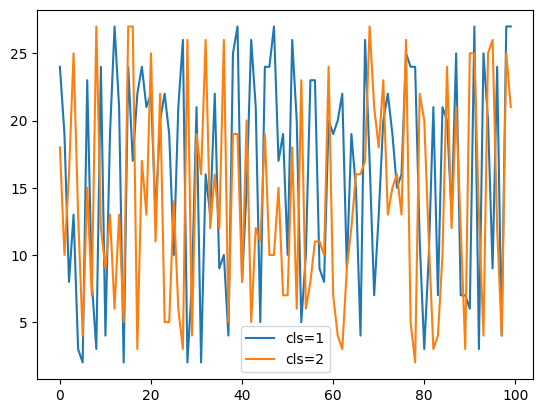

In [48]:
a,b=1,2
plt.plot(clusters[a], label=f'cls={a}')
plt.plot(clusters[b], label=f'cls={b}')
plt.legend()
plt.show()

# Old codes

In [ ]:
aligner = PairwiseAligner()
aligner.mode='global'
aligner.match_score=2.0
aligner.mismatch_score=-1.0
aligner.open_gap_score=-1.0
aligner.extend_gap_score=-0.5


s1 = 'TTTCGTCCCCCCGGACGGTGTCGGT'
s2 = 'GCTCCGACGGGGTCCGTGTTTCCCG'
s3 = 'TCTTTACGCTTCATAGCAGCAATTT'
score = aligner.align(s1, s2)
print(score.score)
print(aligner.match_score)
print(aligner.mismatch_score)
print(aligner.open_gap_score)
print(aligner.extend_gap_score)
print(score)

17.0
2.0
-1.0
-1.0
-0.5


[2 0 0 1 2 0 1 2 0 1]
[[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]]
[[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
Inter-cluster distance: 2.0
Intra-cluster distance: 0.6


In [24]:
def Overlapped_chunk_data(N, num_chunks=4, overlap_percentage=0.3):
    """
    Parameters:
    ==============
        N (int): Size of data
        num_chunks (int) default=4: The number of chunk/windows
        overlap_percentage (float) default=0.3 (30%): Percentage of overlap between adjacent windows/chunks

    Return:
    ==============
        list((start, end)): list of index pair, start and end (exclud)
    """

    # Calculate the chunk size and the overlap size
    chunk_size = N // num_chunks
    overlap_size = int(chunk_size * overlap_percentage)

    # Split the data into chunks with overlap
    chunks = []
    for i in range(num_chunks):
        start = i * (chunk_size - overlap_size)
        end = (i + 1) * chunk_size
        if i == num_chunks - 1:
            end = N
        chunks.append((start, end+1))

    # Print the chunks
    for i, chunk in enumerate(chunks):
        print(f"Chunk {i+1}: {chunks[i]}")

    return chunks

def process_time(start: float, end: float, s=""):
    elapsed = end - start
    hours, remainder = divmod(elapsed, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Time taken{' for ['+s+']' if len(s)>0 else ''}: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

def kmer_frequency(seq, k):
    """
    Calculate k-mer frequencies for a DNA sequence.

    Parameters:
    seq (str): DNA sequence
    k (int): k-mer size

    Returns:
    dict: k-mer frequencies
    """
    return Counter([s[i:i+k] for i in range(len(s)-k+1)])

def get_random_seq(df, clsIds, N=100):
    seq=[]
    cIDs=[]
    
    for c in clsIds:
        seq.extend(df.sequence[df.ClsID==c].sample(N).values.tolist())
        cIDs.extend([c]*N)

    return seq, cIDs

def cluster_sequences(df, num_clusters):
    cls_lbl = np.random.choice(df.ClsID.unique(), size=num_clusters)
    print("Randomly selected cluster ids=",cls_lbl)
    
    return get_random_seq(df, cls_lbl)

def calculate_distances(df, k=2, rep=100, cluster_size=10, sample_size=100):
    """
    Calculate inter-cluster and intra-cluster distances.

    Parameters:
    df: Dataset contains sequences and cluster ids
    cluster_IDs (list): unique cluster labels
    k (int): k-mer size
    rep (int): Repeat the process to compute distribution
    sample_size (int): Number of samples to pull from each cluster
    cluster_size (int): Number of clusters

    Returns:
    Intra_cluster_distance (list): list of intra cluster distance
    Inter_cluster_distance (list): list of inter cluster distance
    """

    cluster_IDs = np.random.choice(df.ClsID.unique(), size=cluster_size)

    inter_CD=[]
    intra_CD=[]

    for _ in range(rep):
        sequences, cluster_labels = get_random_seq(df, cluster_IDs, sample_size)

        # Calculate k-mer frequencies for each sequence
        freqs = [kmer_frequency(seq, k) for seq in sequences]

        # Convert frequencies to numerical representations
        num_freqs = []
        for freq in freqs:
            num_freq = [freq.get(kmer, 0) for kmer in set.union(*[set(f.keys()) for f in freqs])]
            num_freqs.append(num_freq)

        # Calculate inter-cluster distance
        inter_cluster_distance = 0
        for i in set(cluster_labels):
            cluster_freqs = [num_freqs[j] for j in range(len(cluster_labels)) if cluster_labels[j] == i]
            cluster_center = np.mean(cluster_freqs, axis=0)
            inter_cluster_distance += np.sum(pairwise_distances_argmin_min(cluster_center.reshape(-1,1), np.array(cluster_freqs).reshape(-1,1))[1])

        inter_cluster_distance /= len(set(cluster_labels))
        inter_CD.append(inter_cluster_distance)

        # Calculate intra-cluster distance
        intra_cluster_distance = 0
        for i in set(cluster_labels):
            cluster_freqs = [num_freqs[j] for j in range(len(cluster_labels)) if cluster_labels[j] == i]
            intra_cluster_distance += np.sum(pairwise_distances_argmin_min(np.mean(cluster_freqs, axis=0).reshape(-1,1), np.array(cluster_freqs).reshape(-1,1))[1])

        intra_cluster_distance /= len(sequences)
        intra_CD.append(intra_cluster_distance)

    return inter_CD, intra_CD

In [ ]:
aligner = PairwiseAligner()
aligner.mode='global'
aligner.match_score=3.0
aligner.mismatch_score=-1.0
aligner.open_gap_score=-1.0
aligner.extend_gap_score=-0.5

#s1 = "ACGTTAG"
#s2 = "ACTGTAG"
#print(aligner.score(s1, s2))

def get_Kmers(seq, K=2):
    return collections.Counter(itertools.islice(seq, i, i+K) for i in range(len(seq)-k+1))

def compute_distance(sA, sB):
    score = aligner.score(sA, sB)
    return 1/(1+np.exp2(score))

def compute_intra_SD(cid, A=1000, B=100):
    scores = []
    for _ in range(A):
        s1 = data.sequence[data.ClsID==cid].sample(B)
        s2 = data.sequence[data.ClsID==cid].sample(B)
        vis = set()
        
        for a in s1:
            for b in s2:
                if f"{a}#{b}" not in vis:
                    scores.append(compute_distance(a,b))
                    vis.add(f"{a}#{b}")
                    vis.add(f"{b}#{a}")

    print(f"Total alignments={len(scores)}")
    return np.std(scores)

def compute_inter_SID(cid, cIDs, A=1000, B=100):
    scores = []
    print(cid in cIDs)
    
    for _ in range(A):
        s1 = data.sequence[data.ClsID.isin(cIDs)].sample(B)
        s2 = data.sequence[data.ClsID==cid].sample(B)
        
        for a in s1:
            for b in s2:
                try:
                    scores.append(compute_distance(a,b))
                except Exception as e:
                    print(f"Error {e} for sequences ({a}, {b})")

    print(f"Total alignments={len(scores)}")
    return np.std(scores)



cid = tmp.ClsID.sample(1).values[0]
print(cid)
print(f"Intra SD for cluster {cid} is {compute_intra_SD(cid, A=100)}")
print(f"Inter SD for cluster {cid} is {compute_inter_SID(cid, tmp.ClsID[tmp.ClsID!=cid].values.tolist(), A=100)}")


920
Total alignments=999223
Intra SD for cluster 920 is 0.0006547996607558102
False
Total alignments=1000000
Inter SD for cluster 920 is 0.0008955627071672846


In [21]:
cluster_labels = sorted(data.ClsID.unique())
res = Overlapped_chunk_data(len(cluster_labels), num_chunks=4, overlap_percentage=0.8)
for r in res:
    print(f"sbatch runCD.slum {r[0]} {r[1]} /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv")
    #print()

Chunk 1: (0, 312)
Chunk 2: (63, 623)
Chunk 3: (126, 934)
Chunk 4: (189, 1247)
sbatch runCD.slum 0 312 /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv
sbatch runCD.slum 63 623 /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv
sbatch runCD.slum 126 934 /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv
sbatch runCD.slum 189 1247 /home/mkamruz/projects/5UTR/Data output_Aug_7_80.txt gc_content_predictions.csv


In [ ]:
k = 2
num_clusters = 10
num_sample = 1000
num_rep = 100

#st = timeit.default_timer()
#sequences, cluster_labels = cluster_sequences(sample_df, num_clusters)
#et = timeit.default_timer()
#process_time(st, et, "cluster_sequences")

#print(len(sequences), len(cluster_labels))

st = timeit.default_timer()
inter_cluster_distance, intra_cluster_distance = calculate_distances(sample_df, k, num_rep, num_clusters, num_sample)
et = timeit.default_timer()
process_time(st, et, "calculate_distances")

#print("Inter-cluster distance:", inter_cluster_distance)
#print("Intra-cluster distance:", intra_cluster_distance)

In [78]:
# Any sequence belongs to multiple cluster?
tmp = data.groupby('seq_index')['ClsID'].apply(lambda x: x.nunique()).reset_index()
tmp.columns=['seq_index', 'total_clusters']
print(tmp.total_clusters.min(), tmp.total_clusters.max())
del tmp

1 1


In [ ]:
def compute_out_cls_stat(df):
    if len(df)==0: return

    low = int(df['predictions'].min())
    high = int(df['predictions'].max())
    ClsID=[]
    Count=[]
    predictions_std_out=[]
    gc_content_std_out=[]
    predictions_std=[]
    gc_content_std=[]
    freq = {}
    for i in range(low, high+1):
        freq[f"{i}"]=[]
        freq[f"out_{i}"]=[]

    tmp = df.groupby('ClsID')['predictions'].apply(lambda x: len(x)).reset_index()
    tmp = tmp[tmp.predictions>1]

    print(f'Total clusters to process={tmp.ClsID.nunique()}')

    for cid in tmp.ClsID.unique():
        ClsID.append(cid)
        Count.append(df[df.ClsID==cid].shape[0])
        predictions_std_out.append(np.std(df['predictions'][df.ClsID!=cid]))
        gc_content_std_out.append(np.std(df['gc_content'][df.ClsID!=cid]))
        predictions_std.append(np.std(df['predictions'][df.ClsID==cid]))
        gc_content_std.append(np.std(df['gc_content'][df.ClsID==cid]))
        
        '''f = Counter(df['predictions'][df.ClsID==cid].values)
        for k in f:
            freq[f"{k}"].append(f[k])

        f = Counter(df['predictions'][df.ClsID!=cid].values)
        for k in f:
            freq[f"out_{k}"].append(f[k])'''

    d = {'ClsID':ClsID, 
        'predictions_std':predictions_std, 
        'predictions_std_out':predictions_std_out, 
        'gc_content_std':gc_content_std, 
        'gc_content_std_out':gc_content_std_out, 
        'Count':Count}
    
    return pd.DataFrame(d)

'''df_agg = data.groupby('ClsID').agg({
    'predictions': ['std'],#['min', 'mean', 'median', 'std', 'max'],
    'gc_content': ['std', 'count'] #['min', 'mean', 'median', 'std', 'max', 'count']
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'gc_content_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
display(df_agg.head())'''

df_agg= compute_out_cls_stat(data)
df_agg.to_csv(os.path.join(data_path, "whole_cluster_std_inc_exc.csv"), index=False)
display(df_agg.head())

Total clusters to process=21741


ClsID  predictions_std  predictions_std_out  gc_content_std  \
0      1         3.070038             3.078177        0.044123   
1      2         2.784153             3.079508        0.047708   
2      3         2.671473             3.078447        0.040773   
3      4         3.454637             3.078170        0.038717   
4      5         2.682835             3.078288        0.042934   

   gc_content_std_out  Count  
0            0.099996   2647  
1            0.100165  49882  
2            0.099973   4767  
3            0.099967   1487  
4            0.099997   1886

In [24]:
df_agg = pd.read_csv(os.path.join(data_path, "whole_cluster_std_inc_exc.csv"))
print(f"Total clusters to process={df_agg.ClsID.nunique()}")
df_agg.head()

Total clusters to process=21741


ClsID  predictions_std  predictions_std_out  gc_content_std  \
0      1         3.070038             3.078177        0.044123   
1      2         2.784153             3.079508        0.047708   
2      3         2.671473             3.078447        0.040773   
3      4         3.454637             3.078170        0.038717   
4      5         2.682835             3.078288        0.042934   

   gc_content_std_out  Count  
0            0.099996   2647  
1            0.100165  49882  
2            0.099973   4767  
3            0.099967   1487  
4            0.099997   1886

<Figure size 2000x1200 with 0 Axes>

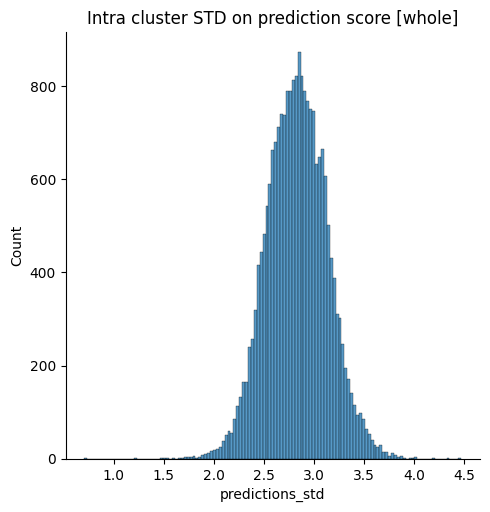

<Figure size 2000x1200 with 0 Axes>

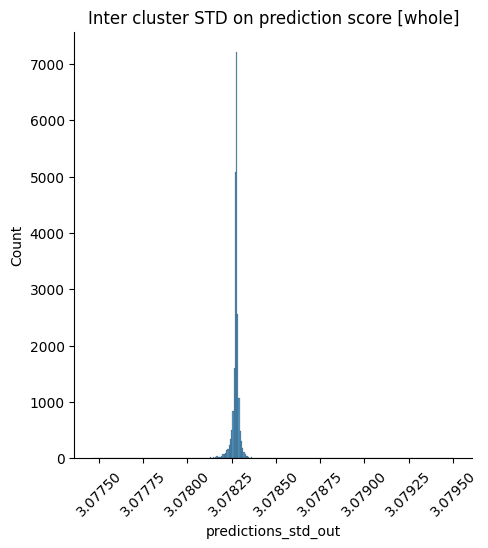

In [25]:
plt.figure(figsize=(20,12))
sns.displot(df_agg.predictions_std, kind='hist')
plt.title('Intra cluster STD on prediction score [whole]')
plt.show()

plt.figure(figsize=(20,12))
sns.displot(df_agg.predictions_std_out, kind='hist')
plt.title('Inter cluster STD on prediction score [whole]')
plt.xticks(rotation=45)
plt.show()

In [27]:
l = [len(x) for x in data.sequence]
min(l), max(l)

(25, 25)

In [79]:
df_agg = data.groupby('ClsID').agg({
    'predictions': ['min', 'mean', 'median', 'std', 'max'],
    'gc_content': ['min', 'mean', 'median', 'std', 'max', 'count']
}).reset_index()
df_agg.columns = df_agg.columns.map('_'.join).str.strip('|')
df_agg.rename(columns={
    'gc_content_count': 'Count',
    'ClsID_':'ClsID'
}, inplace=True)
df_agg.head()

ClsID  predictions_min  predictions_mean  predictions_median  \
0      1                5         18.060446                18.0   
1      2                5         20.024638                20.0   
2      3                8         19.874554                20.0   
3      4                5         18.226631                18.0   
4      5               10         20.909862                21.0   

   predictions_std  predictions_max  gc_content_min  gc_content_mean  \
0         3.070618               26            0.32         0.441390   
1         2.784181               27            0.32         0.473496   
2         2.671754               27            0.28         0.377000   
3         3.455799               27            0.60         0.698319   
4         2.683546               27            0.40         0.507635   

   gc_content_median  gc_content_std  gc_content_max  Count  
0               0.44        0.044131            0.56   2647  
1               0.48        0.047709            0.64  49882  
2               0.36        0.040777            0.48   4767  
3               0.68        0.038730            0.80   1487  
4               0.52        0.042945            0.64   1886

In [80]:
print("Total clusters=",df_agg.ClsID.nunique())
print("Total singleton cluster=",df_agg.ClsID[df_agg.Count==1].shape[0])
print("Total non-singleton cluster=",df_agg.ClsID.nunique() - df_agg.ClsID[df_agg.Count==1].shape[0])

Total clusters= 181136
Total singleton cluster= 159395
Total non-singleton cluster= 21741


In [81]:
df_cnt = df_agg[df_agg.Count>1]
print(df_cnt.shape)
df_cnt.head()

(21741, 12)


ClsID  predictions_min  predictions_mean  predictions_median  \
0      1                5         18.060446                18.0   
1      2                5         20.024638                20.0   
2      3                8         19.874554                20.0   
3      4                5         18.226631                18.0   
4      5               10         20.909862                21.0   

   predictions_std  predictions_max  gc_content_min  gc_content_mean  \
0         3.070618               26            0.32         0.441390   
1         2.784181               27            0.32         0.473496   
2         2.671754               27            0.28         0.377000   
3         3.455799               27            0.60         0.698319   
4         2.683546               27            0.40         0.507635   

   gc_content_median  gc_content_std  gc_content_max  Count  
0               0.44        0.044131            0.56   2647  
1               0.48        0.047709            0.64  49882  
2               0.36        0.040777            0.48   4767  
3               0.68        0.038730            0.80   1487  
4               0.52        0.042945            0.64   1886

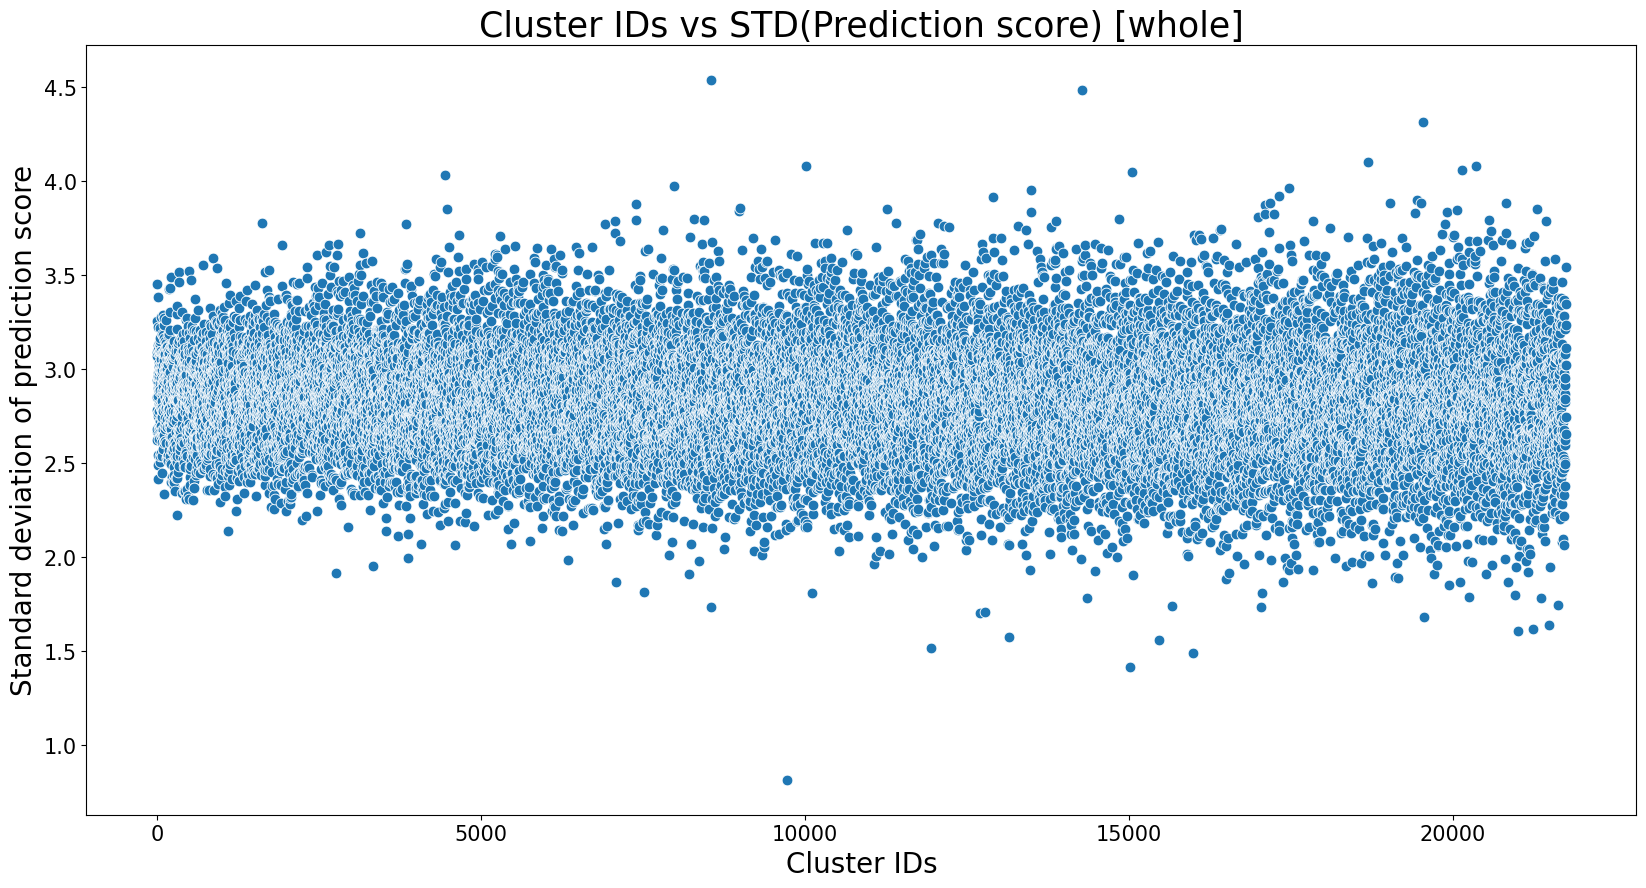

In [84]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.ClsID, y=df_cnt.predictions_std, s=60)
plt.xlabel('Cluster IDs', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of prediction score', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Cluster IDs vs STD(Prediction score) [whole]', fontsize=25)
plt.show()

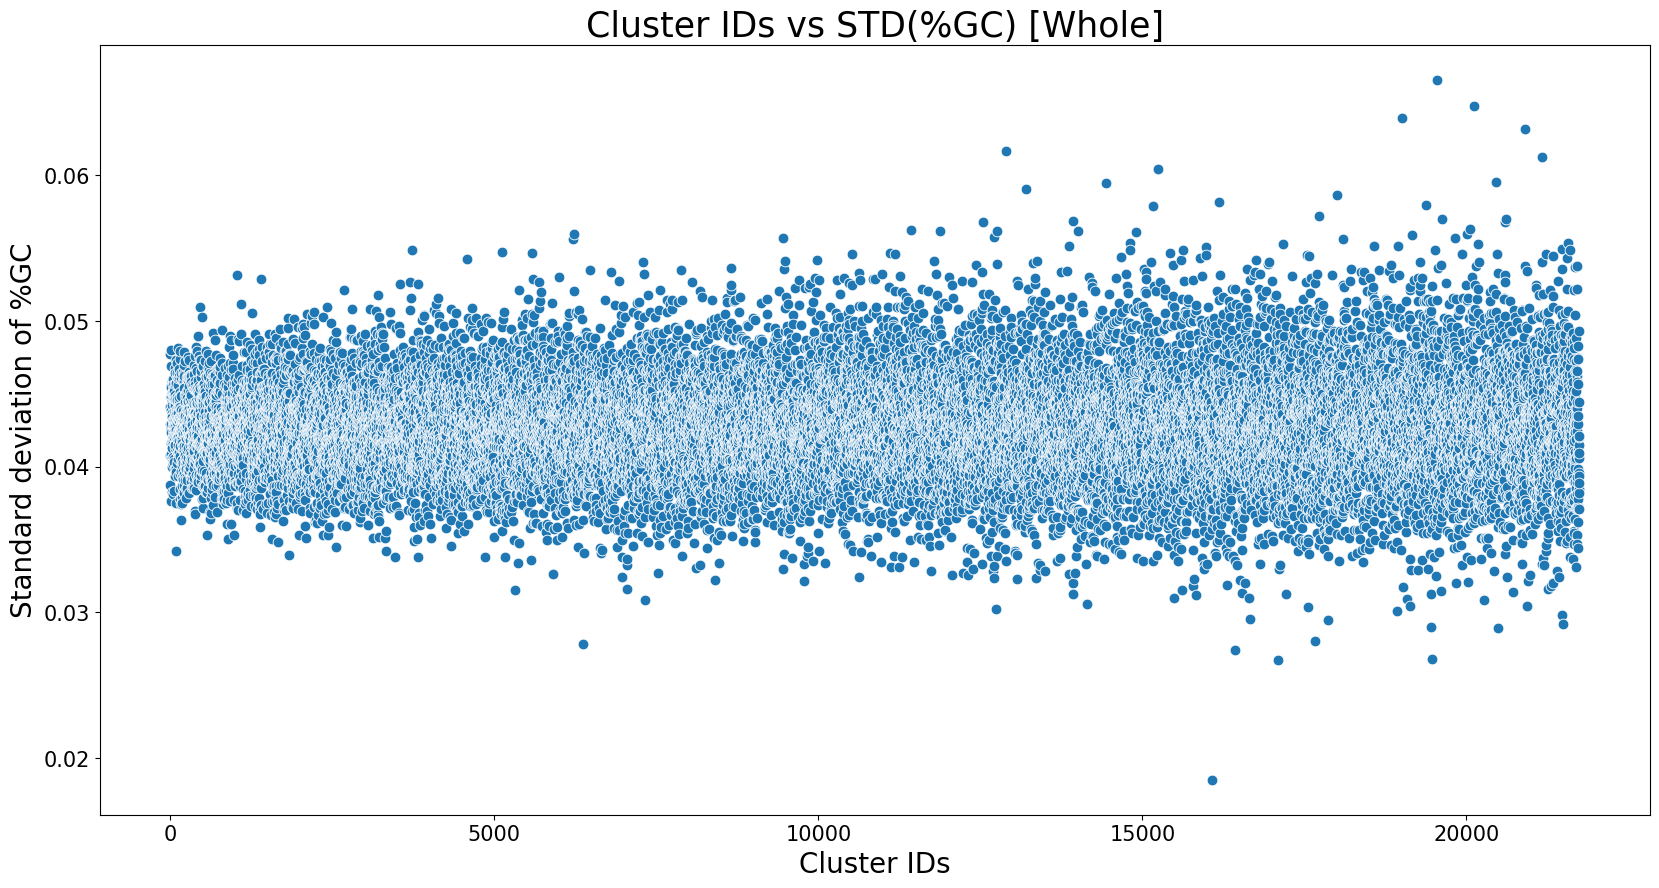

In [85]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.ClsID, y=df_cnt.gc_content_std, s=60)
plt.xlabel('Cluster IDs', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of %GC', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Cluster IDs vs STD(%GC) [Whole]', fontsize=25)
plt.show()

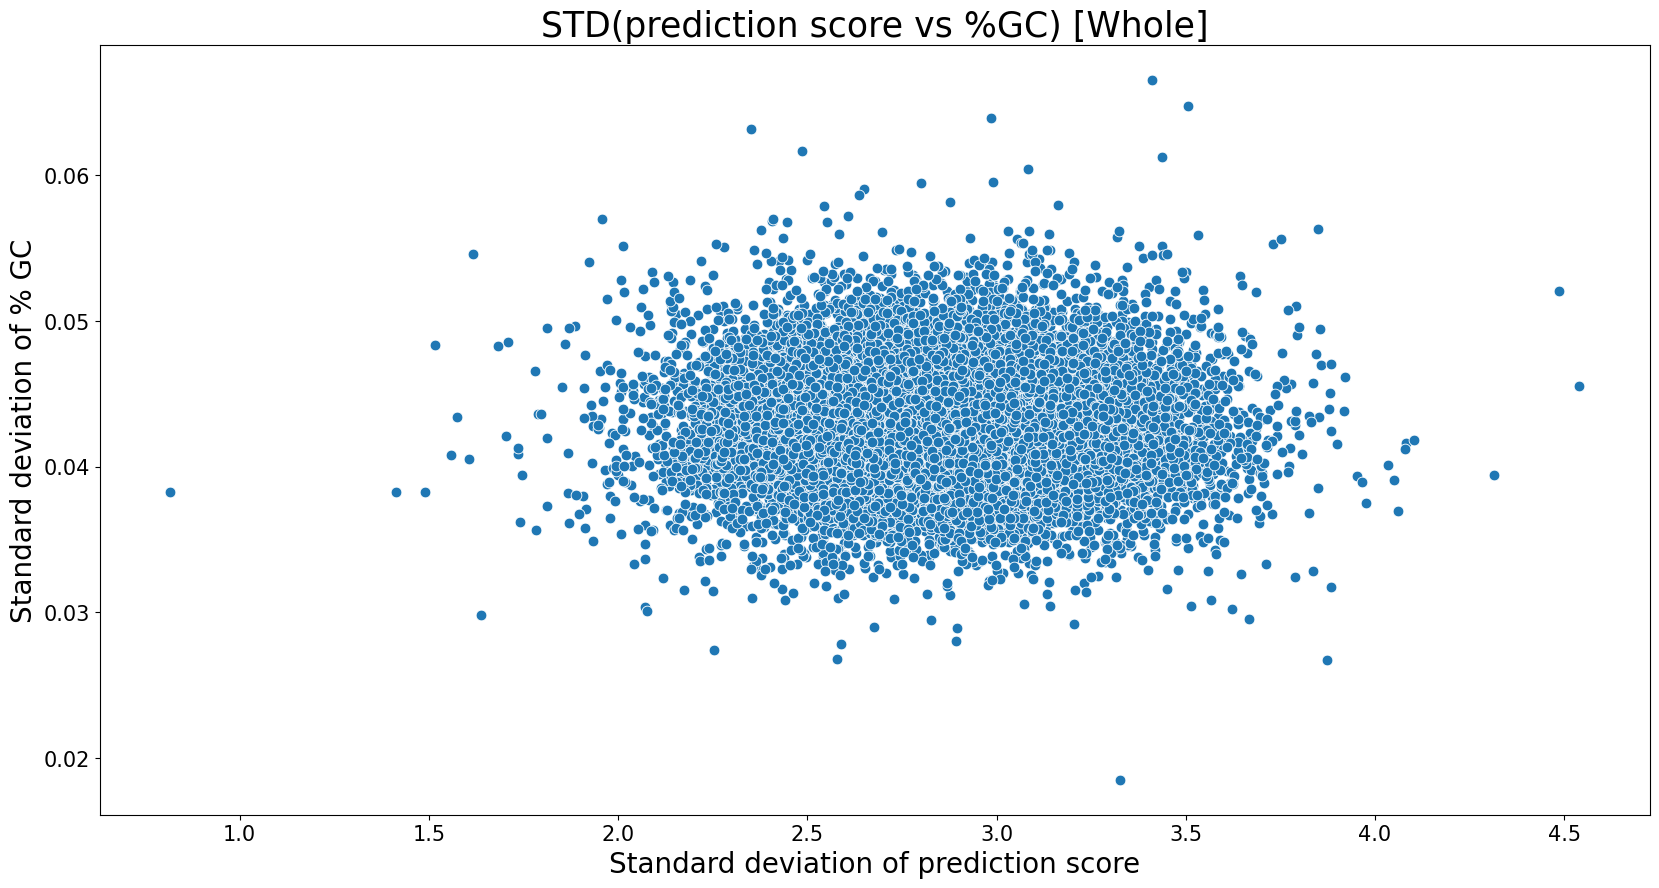

In [86]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_cnt.predictions_std, y=df_cnt.gc_content_std, s=60)
plt.xlabel('Standard deviation of prediction score', fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Standard deviation of % GC', fontsize=20)
plt.yticks(fontsize=15)
plt.title('STD(prediction score vs %GC) [Whole]', fontsize=25)
plt.show()

# Other